In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir('../IConNet/')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
from einops import rearrange, reduce, repeat

In [6]:
dataset_name = 'ravdess'
experiment_prefix = "scb12"
log_dir = f'../{experiment_prefix}_models/{dataset_name}/'
codebook_pretrained_path = f'../scb11_models/ravdess/epoch=220.codebook.pt'
data_dir = "../data/data_preprocessed/"

sr = 16000
batch_size = 2
in_channels = 1
kernel_size = 511
stride = 125
embedding_dim = 511
num_embeddings = 384
cls_dim = 512
learning_rate = 1e-4
max_num_tokens = 768
num_tokens_per_second = 64
num_classes = 4
commitment_cost = 0.1
num_mamba_block=1

In [7]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import get_dataloader
from IConNet.trainer.train_torch import Trainer_SCB10 as Trainer
from IConNet.acov.model import SCB12 as SCB
from omegaconf import OmegaConf as ocf

n_epoch = 4

loss_ratio=VqVaeClsLoss(perplexity=0, loss_vq=0, loss_recon=1, loss_cls=1)

trainer = Trainer(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=4)

dataset_config_path = f'config/dataset/{dataset_name}.yaml'
dataset_config = ocf.load(dataset_config_path)
print(dataset_config)
train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=batch_size)
print(batch_size)

trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size,
               loss_ratio=loss_ratio)

{'name': 'ravdess', 'dataset_class': 'WaveformDataset', 'root': 'ravdess/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label_emotion_key', 'feature_name': 'audio16k', 'num_classes': 8, 'label_values': ['neu', 'cal', 'hap', 'sad', 'ang', 'fea', 'dis', 'sur'], 'classnames': ['neu', 'cal', 'hap', 'sad', 'ang', 'fea', 'dis', 'sur'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}
2


In [9]:
model = SCB(
    in_channels=in_channels,    
    num_embeddings=num_embeddings, 
    stride=stride,
    embedding_dim=embedding_dim, 
    num_classes=num_classes, 
    cls_dim=cls_dim,
    sample_rate=sr,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    num_mamba_block=num_mamba_block,
    num_tokens_per_second=num_tokens_per_second,
    max_num_tokens=max_num_tokens
)

In [10]:
import pandas as pd
import IPython.display as ipd
import seaborn as sns

from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2, get_zcs_color_v2
)

In [11]:
model.codebook_pretrained_path

'../scb11_models/ravdess/epoch=220.codebook.pt'

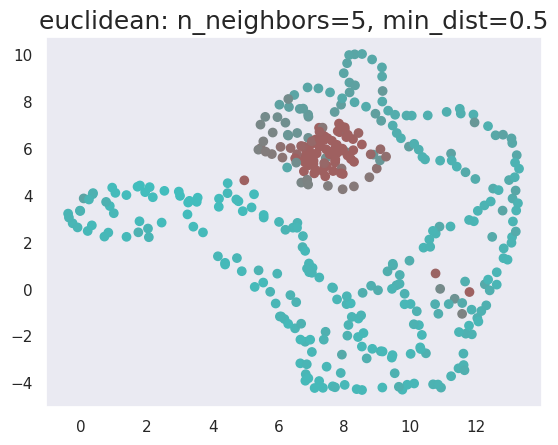

In [12]:
emb = torch.load(model.codebook_pretrained_path)
emb_color, zcs = get_embedding_color_v2(emb)
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(emb, colors=emb_color, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

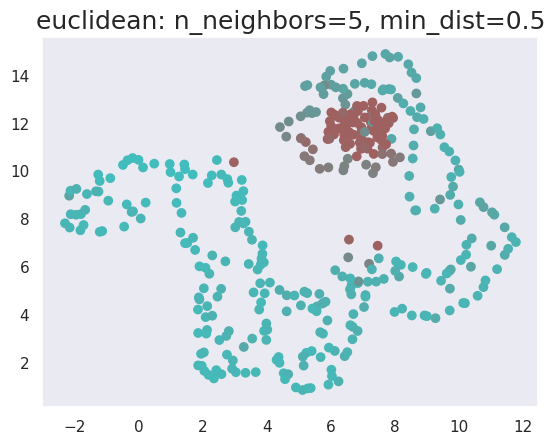

In [13]:
emb = model.filter_codebook.data.cpu()
emb_color, zcs = get_embedding_color_v2(emb)
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(emb, colors=emb_color, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

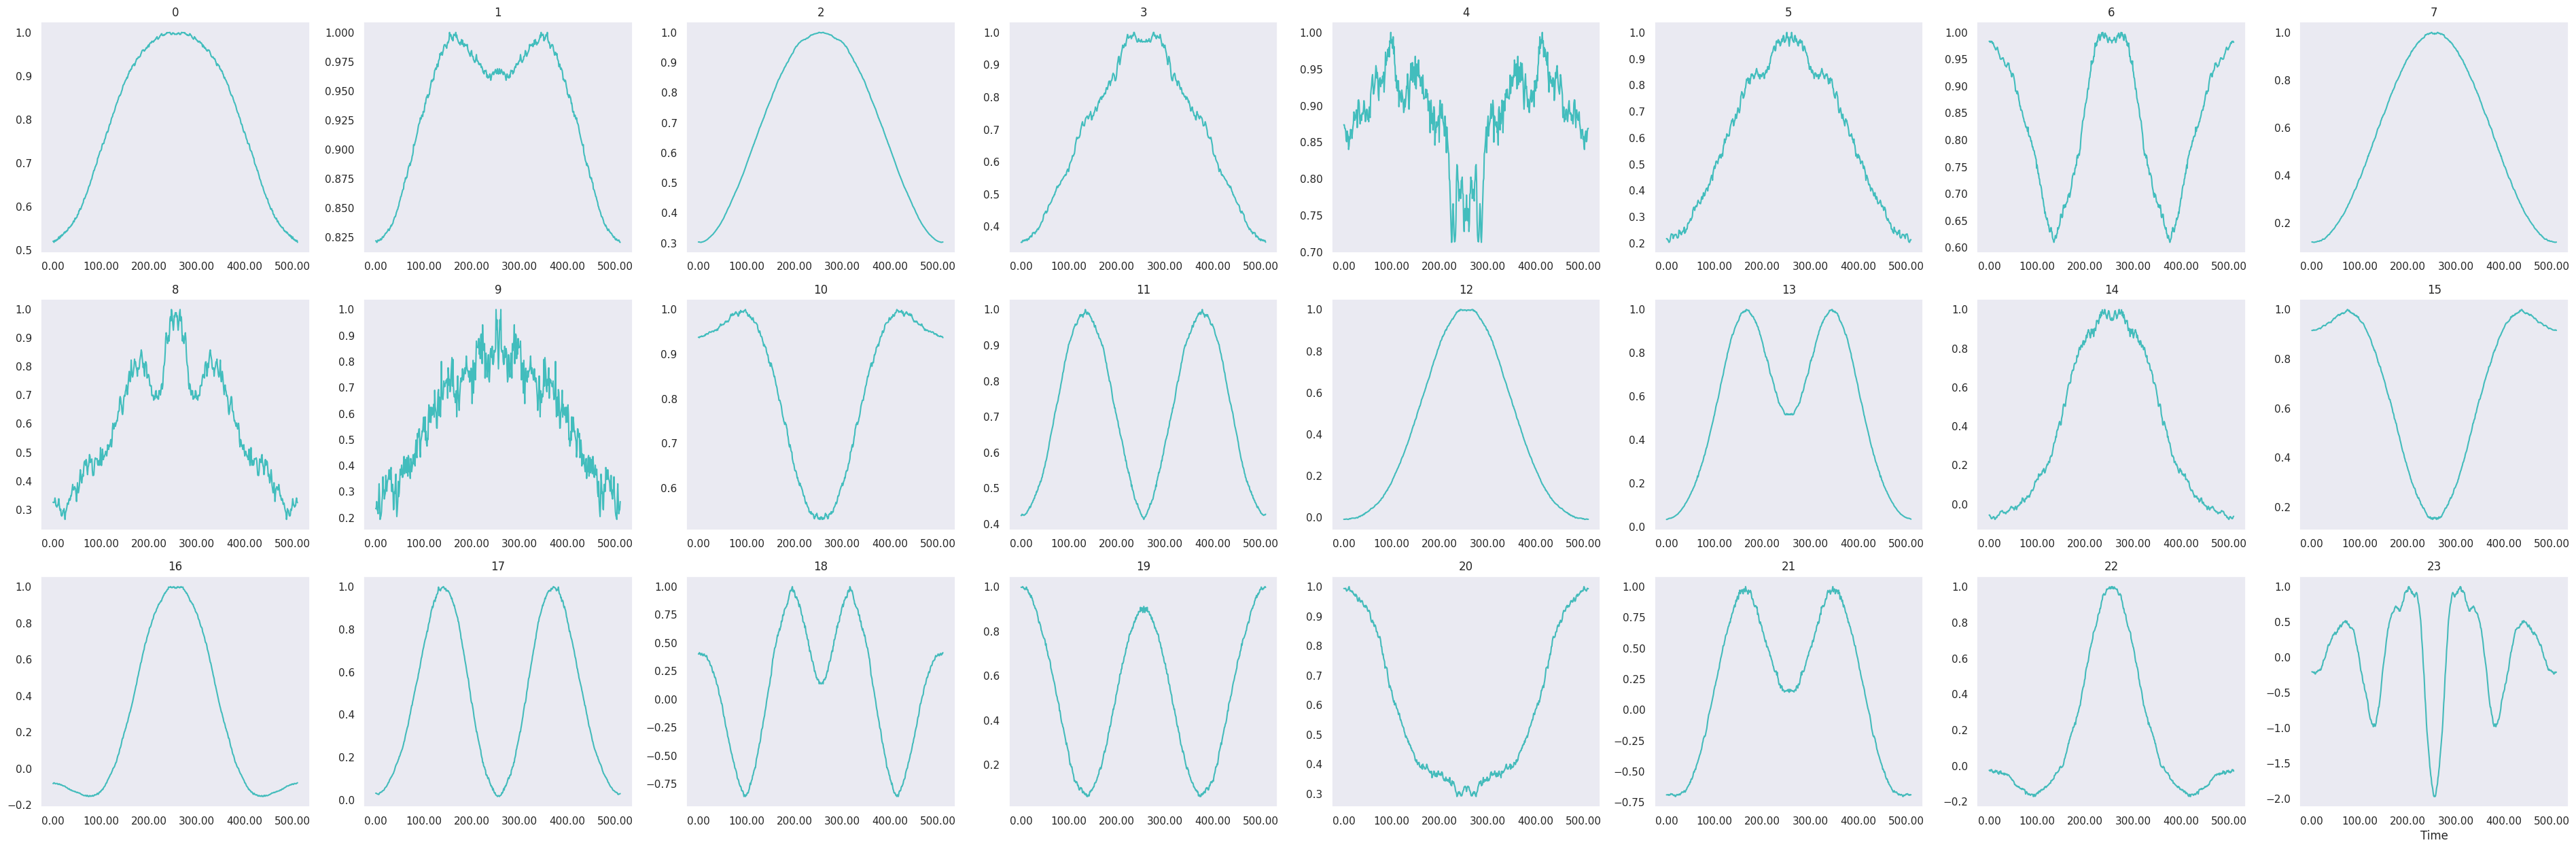

In [14]:
selected_emb_topk = torch.topk(zcs, 24)
selected_idx = selected_emb_topk.indices[-24:]
visualize_speech_codebook(
    emb[selected_idx].numpy(), 
    n=24, colors=emb_color[selected_idx], 
    feature_mel=False, waveplot_librosa=False)

In [15]:
trainer.setup(model=model, lr=learning_rate)

In [16]:
trainer.fit(n_epoch=10, self_supervised=True, train_task='embedding', test_n_epoch=2)

  5%|█▊                                  | 0.503731343283583/10 [00:39<12:13, 77.22s/it]

Epoch: 1	Loss: 4.201 [perplexity=80.311, loss_vq=0.091, loss_recon=4.201, loss_cls=0.000]	


 15%|█████▎                             | 1.503731343283586/10 [02:02<58:41, 414.51s/it]

Epoch: 1	Loss: 5.559 [perplexity=100.780, loss_vq=0.071, loss_recon=3.675, loss_cls=1.883]	Val_acc: 6/27 (22.22%)

Saved new best val model: ../scb12_models/ravdess/model.epoch=1.step=302.loss=5.559.val_acc=0.222.pt


 25%|████████▊                          | 2.5037313432836035/10 [03:20<09:15, 74.08s/it]

Correct: 34/135 (0.2519)
Saved new best test model: ../scb12_models/ravdess/model.epoch=1.step=402.test_acc=0.2519.pt
{'acc_unweighted': tensor(0.2230, device='cuda:0'),
 'acc_weighted': tensor(0.2519, device='cuda:0'),
 'f1s_unweighted': tensor(0.1319, device='cuda:0'),
 'f1s_weighted': tensor(0.1495, device='cuda:0'),
 'rocauc': tensor(0.4197, device='cuda:0'),
 'uar': tensor(0.2230, device='cuda:0'),
 'wap': tensor(0.1336, device='cuda:0')}
{'acc_detail': tensor([0.7895, 0.0000, 0.1026, 0.0000], device='cuda:0'),
 'f1s_detail': tensor([0.3896, 0.0000, 0.1379, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.2586, 0.0000, 0.2105, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.7895, 0.0000, 0.1026, 0.0000], device='cuda:0'),
 'rocauc_detail': tensor([0.3983, 0.3721, 0.4495, 0.4589], device='cuda:0')}
tensor([[30,  0,  8,  0],
        [15,  0,  4,  0],
        [35,  0,  4,  0],
        [36,  0,  3,  0]], device='cuda:0')


 30%|██████████▌                        | 3.0074626865671945/10 [03:59<08:46, 75.25s/it]

Epoch: 2	Loss: 2.981 [perplexity=67.934, loss_vq=0.079, loss_recon=2.981, loss_cls=0.000]	


 40%|██████████████▍                     | 4.007462686567212/10 [05:16<07:43, 77.41s/it]

Epoch: 3	Loss: 3.282 [perplexity=106.598, loss_vq=0.070, loss_recon=3.282, loss_cls=0.000]	


 50%|██████████████████                  | 5.00746268656723/10 [06:39<33:25, 401.66s/it]

Epoch: 3	Loss: 4.789 [perplexity=107.911, loss_vq=0.067, loss_recon=3.556, loss_cls=1.232]	Val_acc: 9/27 (33.33%)

Saved new best val model: ../scb12_models/ravdess/model.epoch=3.step=905.loss=4.789.val_acc=0.333.pt


 60%|█████████████████████▋              | 6.007462686567248/10 [07:55<04:56, 74.21s/it]

Correct: 38/135 (0.2815)
Saved new best test model: ../scb12_models/ravdess/model.epoch=3.step=1005.test_acc=0.2815.pt
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2815, device='cuda:0'),
 'f1s_unweighted': tensor(0.1098, device='cuda:0'),
 'f1s_weighted': tensor(0.1237, device='cuda:0'),
 'rocauc': tensor(0.5671, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0792, device='cuda:0')}
{'acc_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'f1s_detail': tensor([0.4393, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.2815, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'rocauc_detail': tensor([0.5529, 0.6289, 0.5534, 0.5331], device='cuda:0')}
tensor([[38,  0,  0,  0],
        [19,  0,  0,  0],
        [39,  0,  0,  0],
        [39,  0,  0,  0]], device='cuda:0')


 65%|███████████████████████▍            | 6.511194029850839/10 [08:33<04:23, 75.60s/it]

Epoch: 4	Loss: 2.626 [perplexity=52.226, loss_vq=0.080, loss_recon=2.626, loss_cls=0.000]	


 75%|███████████████████████████         | 7.511194029850857/10 [09:50<03:12, 77.42s/it]

Epoch: 5	Loss: 2.938 [perplexity=88.503, loss_vq=0.046, loss_recon=2.938, loss_cls=0.000]	


 85%|█████████████████████████████▊     | 8.511194029850753/10 [11:11<09:55, 400.05s/it]

Epoch: 5	Loss: 4.595 [perplexity=76.512, loss_vq=0.068, loss_recon=3.018, loss_cls=1.578]	Val_acc: 5/27 (18.52%)



 95%|██████████████████████████████████▏ | 9.511194029850532/10 [12:28<00:35, 73.62s/it]

Correct: 38/135 (0.2815)
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2815, device='cuda:0'),
 'f1s_unweighted': tensor(0.1098, device='cuda:0'),
 'f1s_weighted': tensor(0.1237, device='cuda:0'),
 'rocauc': tensor(0.4458, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0792, device='cuda:0')}
{'acc_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'f1s_detail': tensor([0.4393, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.2815, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'rocauc_detail': tensor([0.4645, 0.3072, 0.5243, 0.4874], device='cuda:0')}
tensor([[38,  0,  0,  0],
        [19,  0,  0,  0],
        [39,  0,  0,  0],
        [39,  0,  0,  0]], device='cuda:0')


100%|███████████████████████████████████▉| 9.999999999999678/10 [13:05<00:00, 75.89s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████| 10.014925373134004/10 [13:06<-1:59:59, 76.17s/it]

Epoch: 6	Loss: 2.361 [perplexity=41.129, loss_vq=0.080, loss_recon=2.361, loss_cls=0.000]	


11.014925373133783it [14:22, 76.08s/it]                                                 

Epoch: 7	Loss: 2.982 [perplexity=110.288, loss_vq=0.064, loss_recon=2.982, loss_cls=0.000]	


12.014925373133563it [15:45, 401.20s/it]

Epoch: 7	Loss: 4.608 [perplexity=55.693, loss_vq=0.078, loss_recon=2.724, loss_cls=1.883]	Val_acc: 9/27 (33.33%)



13.014925373133343it [17:01, 73.99s/it] 

Correct: 38/135 (0.2815)
{'acc_unweighted': tensor(0.2436, device='cuda:0'),
 'acc_weighted': tensor(0.2815, device='cuda:0'),
 'f1s_unweighted': tensor(0.1098, device='cuda:0'),
 'f1s_weighted': tensor(0.1269, device='cuda:0'),
 'rocauc': tensor(0.4816, device='cuda:0'),
 'uar': tensor(0.2436, device='cuda:0'),
 'wap': tensor(0.0819, device='cuda:0')}
{'acc_detail': tensor([0.0000, 0.0000, 0.0000, 0.9744], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.0000, 0.0000, 0.4393], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.0000, 0.0000, 0.2836], device='cuda:0'),
 'recall_detail': tensor([0.0000, 0.0000, 0.0000, 0.9744], device='cuda:0'),
 'rocauc_detail': tensor([0.6975, 0.3240, 0.4012, 0.5037], device='cuda:0')}
tensor([[ 0,  0,  0, 38],
        [ 0,  0,  0, 19],
        [ 0,  0,  0, 39],
        [ 0,  0,  1, 38]], device='cuda:0')


13.518656716416814it [17:40, 75.24s/it] 

Epoch: 8	Loss: 2.989 [perplexity=68.524, loss_vq=0.078, loss_recon=2.989, loss_cls=0.000]	


14.518656716416594it [18:56, 76.73s/it] 

Epoch: 9	Loss: 2.728 [perplexity=85.010, loss_vq=0.067, loss_recon=2.728, loss_cls=0.000]	


15.518656716416373it [20:18, 403.78s/it]

Epoch: 9	Loss: 4.470 [perplexity=58.470, loss_vq=0.081, loss_recon=2.685, loss_cls=1.784]	Val_acc: 9/27 (33.33%)



16.518656716416398it [21:35, 73.69s/it] 

Correct: 38/135 (0.2815)
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2815, device='cuda:0'),
 'f1s_unweighted': tensor(0.1098, device='cuda:0'),
 'f1s_weighted': tensor(0.1237, device='cuda:0'),
 'rocauc': tensor(0.5719, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0792, device='cuda:0')}
{'acc_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'f1s_detail': tensor([0.4393, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.2815, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'rocauc_detail': tensor([0.5659, 0.6860, 0.5855, 0.4503], device='cuda:0')}
tensor([[38,  0,  0,  0],
        [19,  0,  0,  0],
        [39,  0,  0,  0],
        [39,  0,  0,  0]], device='cuda:0')


17.02238805970011it [22:14, 75.66s/it] 

Epoch: 10	Loss: 2.020 [perplexity=33.591, loss_vq=0.073, loss_recon=2.020, loss_cls=0.000]	


17.518656716416654it [22:52, 78.33s/it]


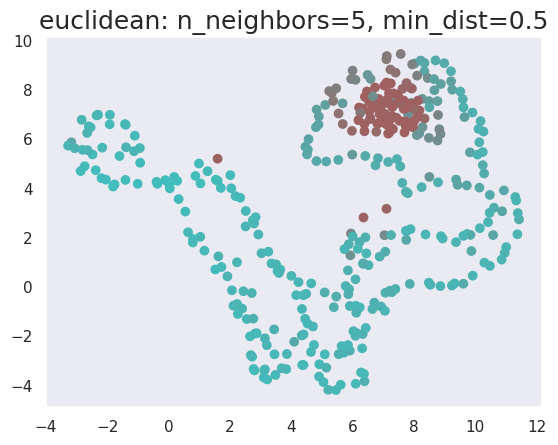

In [17]:
emb_10 = model.filter_codebook.data.cpu()
emb_color_10, zcs_10 = get_embedding_color_v2(emb_10)
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(emb_10, colors=emb_color_10, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

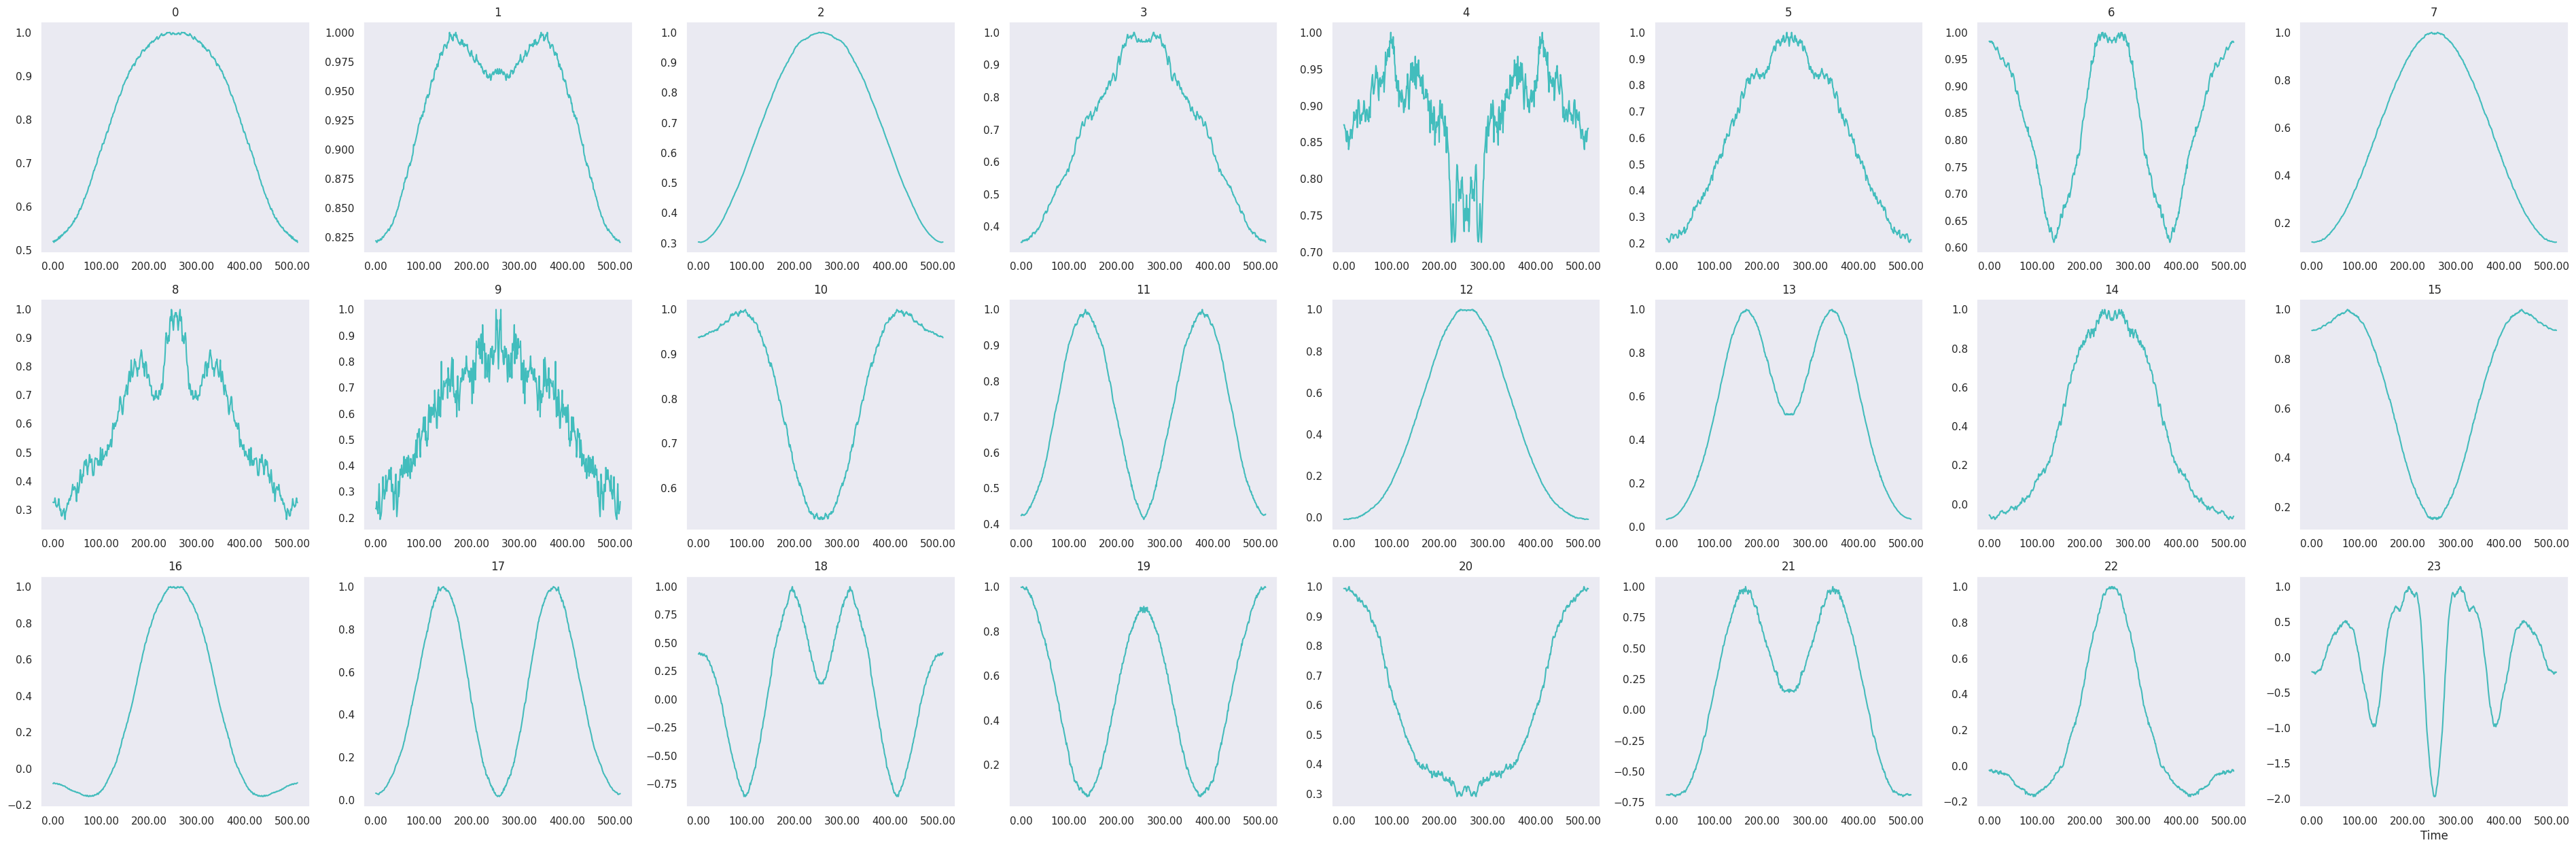

In [18]:
visualize_speech_codebook(
    emb_10[selected_idx].numpy(), 
    n=24, colors=emb_color_10[selected_idx], 
    feature_mel=False, waveplot_librosa=False)

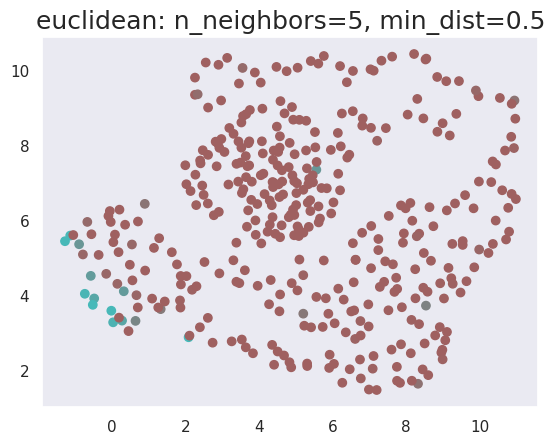

In [19]:
latent_emb_10 = model.latent_codebook.data.cpu()
latent_color_10, latent_zcs_10 = get_embedding_color_v2(latent_emb_10)
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(latent_emb_10, colors=latent_color_10, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

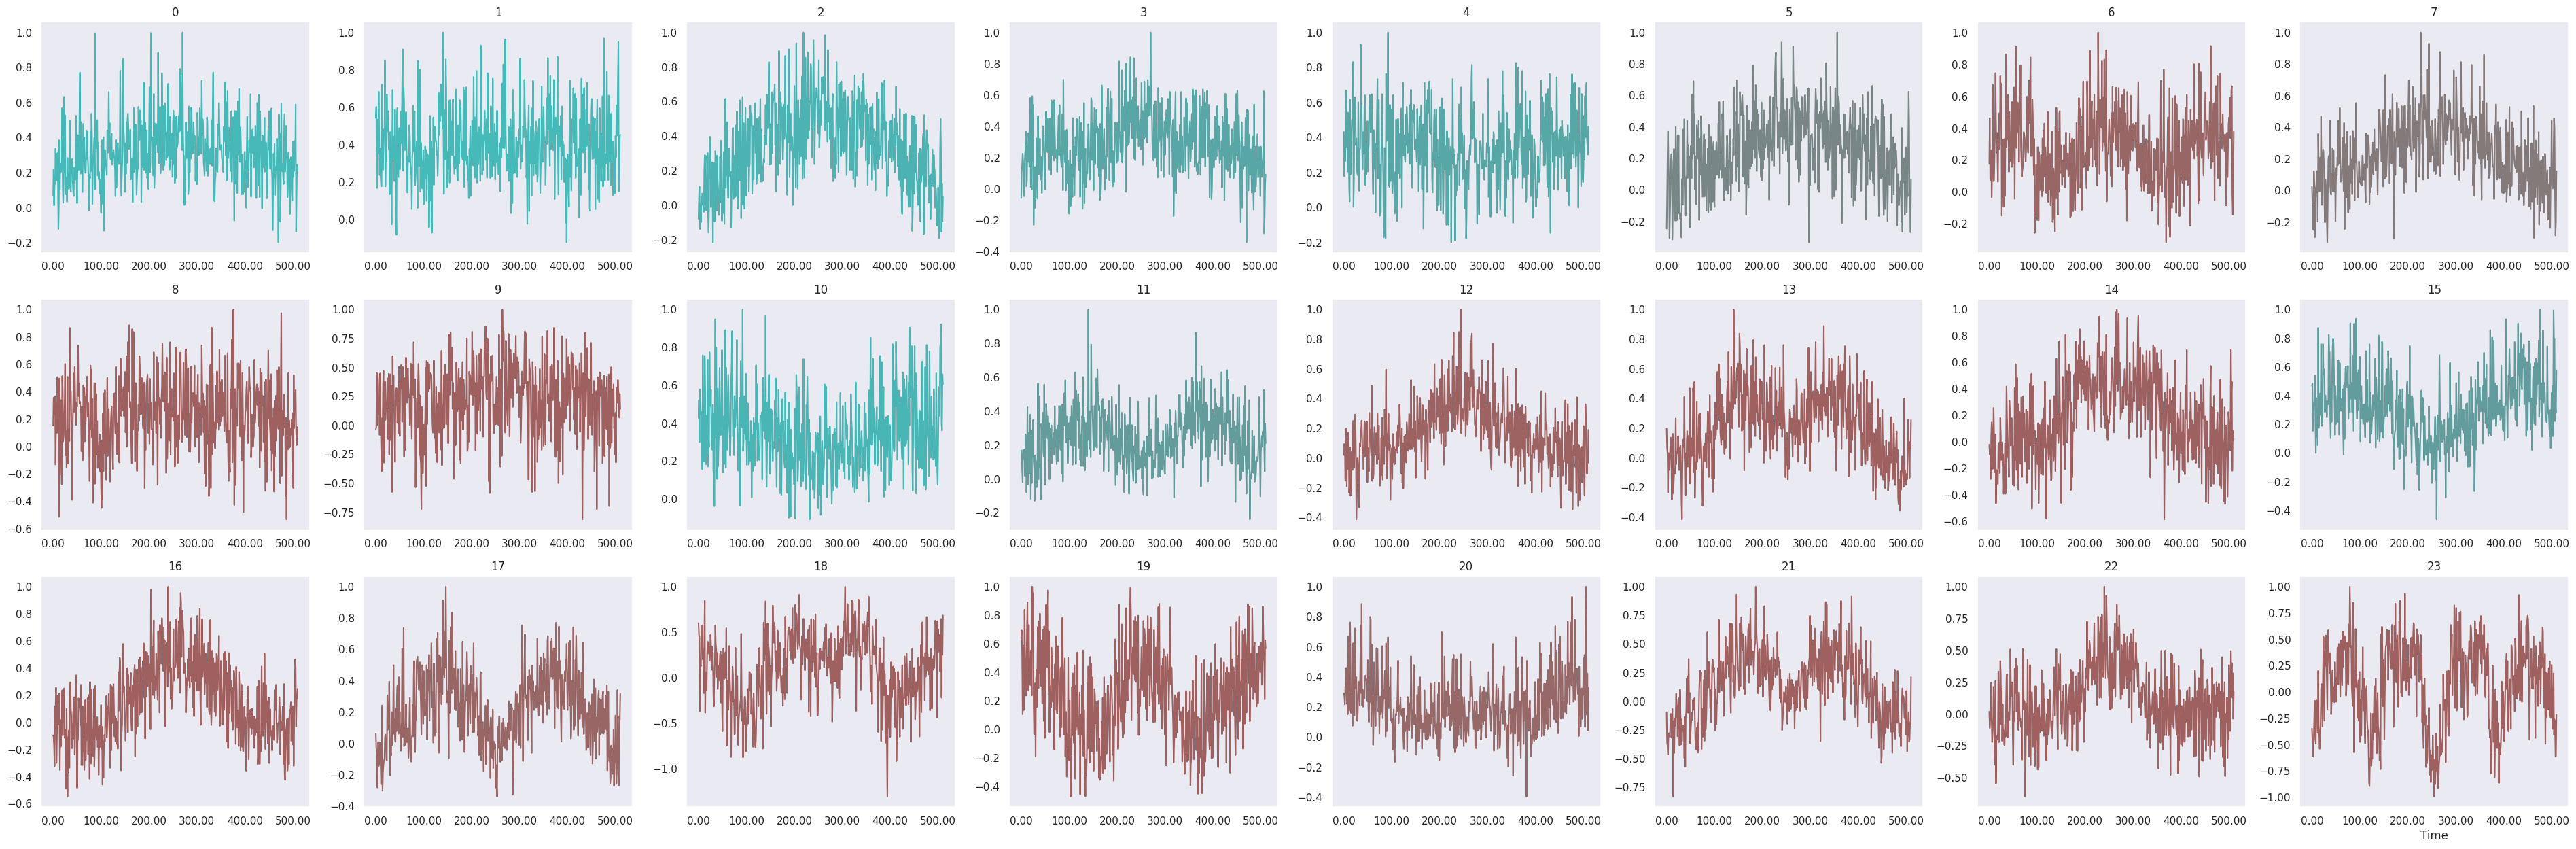

In [20]:
visualize_speech_codebook(
    latent_emb_10[selected_idx].numpy(), 
    n=24, colors=latent_color_10[selected_idx], 
    feature_mel=False, waveplot_librosa=False)

In [21]:
trainer.fit(n_epoch=500, self_supervised=True, train_task='embedding', test_n_epoch=50)

  0%|                                | 0.503731343283583/500 [00:38<10:36:34, 76.47s/it]

Epoch: 11	Loss: 1.740 [perplexity=48.366, loss_vq=0.077, loss_recon=1.740, loss_cls=0.000]	


  0%|                               | 1.503731343283586/500 [02:02<58:04:47, 419.44s/it]

Epoch: 11	Loss: 3.219 [perplexity=99.326, loss_vq=0.063, loss_recon=2.129, loss_cls=1.089]	Val_acc: 6/27 (22.22%)



  1%|▏                              | 2.5037313432836035/500 [03:19<10:21:25, 74.95s/it]

Correct: 42/135 (0.3111)
Saved new best test model: ../scb12_models/ravdess/model.epoch=11.step=3417.test_acc=0.3111.pt
{'acc_unweighted': tensor(0.2699, device='cuda:0'),
 'acc_weighted': tensor(0.3111, device='cuda:0'),
 'f1s_unweighted': tensor(0.1723, device='cuda:0'),
 'f1s_weighted': tensor(0.1977, device='cuda:0'),
 'rocauc': tensor(0.5217, device='cuda:0'),
 'uar': tensor(0.2699, device='cuda:0'),
 'wap': tensor(0.3541, device='cuda:0')}
{'acc_detail': tensor([0.1053, 0.0000, 0.9487, 0.0256], device='cuda:0'),
 'f1s_detail': tensor([0.1860, 0.0000, 0.4596, 0.0435], device='cuda:0'),
 'precision_detail': tensor([0.8000, 0.0000, 0.3033, 0.1429], device='cuda:0'),
 'recall_detail': tensor([0.1053, 0.0000, 0.9487, 0.0256], device='cuda:0'),
 'rocauc_detail': tensor([0.6782, 0.3793, 0.5304, 0.4987], device='cuda:0')}
tensor([[ 4,  0, 31,  3],
        [ 0,  0, 17,  2],
        [ 0,  1, 37,  1],
        [ 1,  0, 37,  1]], device='cuda:0')


  1%|▏                              | 3.0074626865671945/500 [03:59<10:50:35, 78.54s/it]

Epoch: 12	Loss: 1.925 [perplexity=83.971, loss_vq=0.086, loss_recon=1.925, loss_cls=0.000]	


  1%|▎                               | 4.007462686567212/500 [05:18<10:42:04, 77.67s/it]

Epoch: 13	Loss: 2.280 [perplexity=77.268, loss_vq=0.048, loss_recon=2.280, loss_cls=0.000]	


  1%|▎                                | 5.00746268656723/500 [06:36<11:00:28, 80.06s/it]

Epoch: 14	Loss: 2.253 [perplexity=95.086, loss_vq=0.048, loss_recon=2.253, loss_cls=0.000]	


  1%|▍                               | 6.007462686567248/500 [07:54<10:37:30, 77.43s/it]

Epoch: 15	Loss: 1.585 [perplexity=56.537, loss_vq=0.066, loss_recon=1.585, loss_cls=0.000]	


  1%|▍                               | 7.007462686567266/500 [09:11<10:30:35, 76.75s/it]

Epoch: 16	Loss: 1.884 [perplexity=70.142, loss_vq=0.070, loss_recon=1.884, loss_cls=0.000]	


  2%|▌                               | 8.007462686567282/500 [10:29<10:36:19, 77.60s/it]

Epoch: 17	Loss: 2.270 [perplexity=89.223, loss_vq=0.055, loss_recon=2.270, loss_cls=0.000]	


  2%|▌                               | 9.007462686567061/500 [11:47<10:33:09, 77.37s/it]

Epoch: 18	Loss: 1.367 [perplexity=40.229, loss_vq=0.085, loss_recon=1.367, loss_cls=0.000]	


  2%|▌                              | 10.007462686566841/500 [13:06<10:46:04, 79.11s/it]

Epoch: 19	Loss: 2.008 [perplexity=110.370, loss_vq=0.071, loss_recon=2.008, loss_cls=0.000]	


  2%|▋                               | 11.00746268656662/500 [14:24<10:28:53, 77.16s/it]

Epoch: 20	Loss: 2.107 [perplexity=100.826, loss_vq=0.065, loss_recon=2.107, loss_cls=0.000]	


  2%|▊                                | 12.0074626865664/500 [15:43<10:39:32, 78.63s/it]

Epoch: 21	Loss: 1.836 [perplexity=49.191, loss_vq=0.084, loss_recon=1.836, loss_cls=0.000]	


  3%|▊                               | 13.00746268656618/500 [17:02<10:31:12, 77.77s/it]

Epoch: 22	Loss: 1.746 [perplexity=90.377, loss_vq=0.073, loss_recon=1.746, loss_cls=0.000]	


  3%|▉                               | 14.00746268656596/500 [18:20<10:47:23, 79.93s/it]

Epoch: 23	Loss: 1.655 [perplexity=65.843, loss_vq=0.084, loss_recon=1.655, loss_cls=0.000]	


  3%|▉                               | 15.00746268656574/500 [19:40<10:41:27, 79.36s/it]

Epoch: 24	Loss: 1.622 [perplexity=69.987, loss_vq=0.066, loss_recon=1.622, loss_cls=0.000]	


  3%|█                               | 16.00746268656552/500 [20:59<10:41:48, 79.56s/it]

Epoch: 25	Loss: 1.853 [perplexity=64.207, loss_vq=0.058, loss_recon=1.853, loss_cls=0.000]	


  3%|█                              | 17.007462686565777/500 [22:17<10:33:26, 78.69s/it]

Epoch: 26	Loss: 2.006 [perplexity=103.948, loss_vq=0.054, loss_recon=2.006, loss_cls=0.000]	


  4%|█                              | 18.007462686566033/500 [23:35<10:25:34, 77.87s/it]

Epoch: 27	Loss: 1.493 [perplexity=63.560, loss_vq=0.073, loss_recon=1.493, loss_cls=0.000]	


  4%|█▏                              | 19.00746268656629/500 [24:53<10:23:07, 77.73s/it]

Epoch: 28	Loss: 1.839 [perplexity=80.961, loss_vq=0.081, loss_recon=1.839, loss_cls=0.000]	


  4%|█▏                             | 20.007462686566544/500 [26:11<10:24:47, 78.10s/it]

Epoch: 29	Loss: 1.203 [perplexity=53.910, loss_vq=0.076, loss_recon=1.203, loss_cls=0.000]	


  4%|█▍                               | 21.0074626865668/500 [27:29<10:16:56, 77.28s/it]

Epoch: 30	Loss: 1.024 [perplexity=33.215, loss_vq=0.082, loss_recon=1.024, loss_cls=0.000]	


  4%|█▎                             | 22.007462686567056/500 [28:47<10:19:04, 77.71s/it]

Epoch: 31	Loss: 1.388 [perplexity=67.410, loss_vq=0.085, loss_recon=1.388, loss_cls=0.000]	


  5%|█▍                              | 23.00746268656731/500 [30:05<10:17:51, 77.72s/it]

Epoch: 32	Loss: 1.789 [perplexity=79.386, loss_vq=0.058, loss_recon=1.789, loss_cls=0.000]	


  5%|█▍                             | 24.007462686567568/500 [31:23<10:15:47, 77.62s/it]

Epoch: 33	Loss: 1.293 [perplexity=48.882, loss_vq=0.084, loss_recon=1.293, loss_cls=0.000]	


  5%|█▌                             | 25.007462686567823/500 [32:41<10:22:43, 78.66s/it]

Epoch: 34	Loss: 1.378 [perplexity=72.261, loss_vq=0.069, loss_recon=1.378, loss_cls=0.000]	


  5%|█▋                              | 26.00746268656808/500 [34:00<10:26:29, 79.30s/it]

Epoch: 35	Loss: 1.410 [perplexity=68.578, loss_vq=0.066, loss_recon=1.410, loss_cls=0.000]	


  5%|█▋                             | 27.007462686568335/500 [35:18<10:18:44, 78.49s/it]

Epoch: 36	Loss: 1.098 [perplexity=56.146, loss_vq=0.077, loss_recon=1.098, loss_cls=0.000]	


  6%|█▊                              | 28.00746268656859/500 [36:36<10:11:57, 77.79s/it]

Epoch: 37	Loss: 1.810 [perplexity=109.444, loss_vq=0.063, loss_recon=1.810, loss_cls=0.000]	


  6%|█▊                             | 29.007462686568847/500 [37:55<10:09:38, 77.66s/it]

Epoch: 38	Loss: 1.420 [perplexity=99.350, loss_vq=0.055, loss_recon=1.420, loss_cls=0.000]	


  6%|█▊                             | 30.007462686569102/500 [39:13<10:13:45, 78.35s/it]

Epoch: 39	Loss: 0.866 [perplexity=76.655, loss_vq=0.088, loss_recon=0.866, loss_cls=0.000]	


  6%|█▉                             | 31.007462686569358/500 [40:31<10:07:31, 77.72s/it]

Epoch: 40	Loss: 1.216 [perplexity=36.174, loss_vq=0.076, loss_recon=1.216, loss_cls=0.000]	


  6%|██                              | 32.00746268656961/500 [41:50<10:14:39, 78.80s/it]

Epoch: 41	Loss: 1.175 [perplexity=39.022, loss_vq=0.079, loss_recon=1.175, loss_cls=0.000]	


  7%|██                             | 33.007462686569866/500 [43:08<10:04:53, 77.72s/it]

Epoch: 42	Loss: 1.343 [perplexity=135.898, loss_vq=0.067, loss_recon=1.343, loss_cls=0.000]	


  7%|██▏                             | 34.00746268657012/500 [44:27<10:05:19, 77.94s/it]

Epoch: 43	Loss: 1.273 [perplexity=95.669, loss_vq=0.067, loss_recon=1.273, loss_cls=0.000]	


  7%|██▏                             | 35.00746268657038/500 [45:46<10:04:36, 78.01s/it]

Epoch: 44	Loss: 1.289 [perplexity=133.594, loss_vq=0.068, loss_recon=1.289, loss_cls=0.000]	


  7%|██▎                             | 36.00746268657063/500 [47:04<10:01:42, 77.81s/it]

Epoch: 45	Loss: 1.548 [perplexity=80.775, loss_vq=0.073, loss_recon=1.548, loss_cls=0.000]	


  7%|██▎                             | 37.00746268657089/500 [48:22<10:02:05, 78.03s/it]

Epoch: 46	Loss: 1.100 [perplexity=55.998, loss_vq=0.081, loss_recon=1.100, loss_cls=0.000]	


  8%|██▍                             | 38.007462686571145/500 [49:41<9:57:48, 77.64s/it]

Epoch: 47	Loss: 1.267 [perplexity=64.744, loss_vq=0.079, loss_recon=1.267, loss_cls=0.000]	


  8%|██▋                               | 39.0074626865714/500 [50:59<9:59:54, 78.08s/it]

Epoch: 48	Loss: 1.248 [perplexity=84.415, loss_vq=0.077, loss_recon=1.248, loss_cls=0.000]	


  8%|██▌                             | 40.00746268657166/500 [52:18<10:08:40, 79.39s/it]

Epoch: 49	Loss: 1.160 [perplexity=118.417, loss_vq=0.064, loss_recon=1.160, loss_cls=0.000]	


  8%|██▌                             | 41.00746268657191/500 [53:37<10:04:49, 79.06s/it]

Epoch: 50	Loss: 1.228 [perplexity=88.365, loss_vq=0.060, loss_recon=1.228, loss_cls=0.000]	


  8%|██▊                              | 42.00746268657217/500 [54:56<9:53:21, 77.73s/it]

Epoch: 51	Loss: 1.149 [perplexity=54.272, loss_vq=0.061, loss_recon=1.149, loss_cls=0.000]	


  9%|██▊                             | 43.007462686572424/500 [56:14<9:58:56, 78.64s/it]

Epoch: 52	Loss: 0.959 [perplexity=53.018, loss_vq=0.077, loss_recon=0.959, loss_cls=0.000]	


  9%|██▉                              | 44.00746268657268/500 [57:33<9:57:59, 78.68s/it]

Epoch: 53	Loss: 1.169 [perplexity=105.967, loss_vq=0.067, loss_recon=1.169, loss_cls=0.000]	


  9%|██▉                             | 45.007462686572936/500 [58:51<9:52:22, 78.12s/it]

Epoch: 54	Loss: 0.794 [perplexity=34.235, loss_vq=0.077, loss_recon=0.794, loss_cls=0.000]	


  9%|██▊                            | 46.00746268657319/500 [1:00:10<9:50:35, 78.05s/it]

Epoch: 55	Loss: 1.456 [perplexity=107.562, loss_vq=0.051, loss_recon=1.456, loss_cls=0.000]	


  9%|██▉                            | 47.00746268657345/500 [1:01:29<9:50:21, 78.19s/it]

Epoch: 56	Loss: 0.903 [perplexity=71.557, loss_vq=0.075, loss_recon=0.903, loss_cls=0.000]	


 10%|███                             | 48.0074626865737/500 [1:02:48<9:53:39, 78.81s/it]

Epoch: 57	Loss: 0.923 [perplexity=91.484, loss_vq=0.090, loss_recon=0.923, loss_cls=0.000]	


 10%|███                            | 49.00746268657396/500 [1:04:07<9:52:14, 78.79s/it]

Epoch: 58	Loss: 1.197 [perplexity=108.430, loss_vq=0.077, loss_recon=1.197, loss_cls=0.000]	


 10%|███                           | 50.007462686574215/500 [1:05:26<9:52:00, 78.94s/it]

Epoch: 59	Loss: 0.953 [perplexity=64.962, loss_vq=0.075, loss_recon=0.953, loss_cls=0.000]	


 10%|███▏                           | 51.00746268657447/500 [1:06:45<9:51:14, 79.01s/it]

Epoch: 60	Loss: 0.907 [perplexity=70.720, loss_vq=0.084, loss_recon=0.907, loss_cls=0.000]	


 10%|███                           | 52.007462686574726/500 [1:08:04<9:44:42, 78.31s/it]

Epoch: 61	Loss: 1.120 [perplexity=80.847, loss_vq=0.069, loss_recon=1.120, loss_cls=0.000]	


 11%|███                          | 53.00746268657498/500 [1:09:29<53:07:29, 427.86s/it]

Epoch: 61	Loss: 2.931 [perplexity=115.593, loss_vq=0.050, loss_recon=1.204, loss_cls=1.727]	Val_acc: 8/27 (29.63%)



 11%|███▎                           | 54.00746268657524/500 [1:10:48<9:29:15, 76.58s/it]

Correct: 39/135 (0.2889)
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2889, device='cuda:0'),
 'f1s_unweighted': tensor(0.1121, device='cuda:0'),
 'f1s_weighted': tensor(0.1295, device='cuda:0'),
 'rocauc': tensor(0.5370, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0835, device='cuda:0')}
{'acc_detail': tensor([0., 0., 1., 0.], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.0000, 0.4483, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.0000, 0.2889, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0., 0., 1., 0.], device='cuda:0'),
 'rocauc_detail': tensor([0.6484, 0.5086, 0.4776, 0.5134], device='cuda:0')}
tensor([[ 0,  0, 38,  0],
        [ 0,  0, 19,  0],
        [ 0,  0, 39,  0],
        [ 0,  0, 39,  0]], device='cuda:0')


 11%|███▍                           | 54.51119402985895/500 [1:11:28<9:43:34, 78.60s/it]

Epoch: 62	Loss: 0.615 [perplexity=22.308, loss_vq=0.070, loss_recon=0.615, loss_cls=0.000]	


 11%|███▎                          | 55.511194029859205/500 [1:12:48<9:42:10, 78.59s/it]

Epoch: 63	Loss: 0.822 [perplexity=91.044, loss_vq=0.083, loss_recon=0.822, loss_cls=0.000]	


 11%|███▌                           | 56.51119402985946/500 [1:14:07<9:40:42, 78.57s/it]

Epoch: 64	Loss: 1.017 [perplexity=67.594, loss_vq=0.064, loss_recon=1.017, loss_cls=0.000]	


 12%|███▍                          | 57.511194029859716/500 [1:15:26<9:36:45, 78.21s/it]

Epoch: 65	Loss: 0.991 [perplexity=85.493, loss_vq=0.084, loss_recon=0.991, loss_cls=0.000]	


 12%|███▋                           | 58.51119402985997/500 [1:16:45<9:48:56, 80.04s/it]

Epoch: 66	Loss: 0.874 [perplexity=84.190, loss_vq=0.085, loss_recon=0.874, loss_cls=0.000]	


 12%|███▋                           | 59.51119402986023/500 [1:18:04<9:39:37, 78.95s/it]

Epoch: 67	Loss: 0.828 [perplexity=93.416, loss_vq=0.070, loss_recon=0.828, loss_cls=0.000]	


 12%|███▋                          | 60.511194029860484/500 [1:19:23<9:38:16, 78.95s/it]

Epoch: 68	Loss: 0.798 [perplexity=101.358, loss_vq=0.072, loss_recon=0.798, loss_cls=0.000]	


 12%|███▊                           | 61.51119402986074/500 [1:20:43<9:33:24, 78.46s/it]

Epoch: 69	Loss: 1.099 [perplexity=50.868, loss_vq=0.083, loss_recon=1.099, loss_cls=0.000]	


 13%|███▊                          | 62.511194029860995/500 [1:22:02<9:36:08, 79.01s/it]

Epoch: 70	Loss: 0.787 [perplexity=98.306, loss_vq=0.070, loss_recon=0.787, loss_cls=0.000]	


 13%|███▉                           | 63.51119402986125/500 [1:23:21<9:32:31, 78.70s/it]

Epoch: 71	Loss: 0.998 [perplexity=84.701, loss_vq=0.069, loss_recon=0.998, loss_cls=0.000]	


 13%|███▉                           | 64.51119402986053/500 [1:24:40<9:27:44, 78.22s/it]

Epoch: 72	Loss: 0.905 [perplexity=60.478, loss_vq=0.070, loss_recon=0.905, loss_cls=0.000]	


 13%|████                           | 65.51119402985888/500 [1:25:59<9:29:07, 78.59s/it]

Epoch: 73	Loss: 0.851 [perplexity=51.906, loss_vq=0.072, loss_recon=0.851, loss_cls=0.000]	


 13%|████                           | 66.51119402985724/500 [1:27:19<9:26:29, 78.41s/it]

Epoch: 74	Loss: 0.897 [perplexity=133.824, loss_vq=0.065, loss_recon=0.897, loss_cls=0.000]	


 14%|████▏                          | 67.51119402985559/500 [1:28:38<9:28:44, 78.90s/it]

Epoch: 75	Loss: 1.104 [perplexity=109.060, loss_vq=0.076, loss_recon=1.104, loss_cls=0.000]	


 14%|████▏                          | 68.51119402985394/500 [1:29:57<9:30:58, 79.40s/it]

Epoch: 76	Loss: 1.038 [perplexity=107.864, loss_vq=0.078, loss_recon=1.038, loss_cls=0.000]	


 14%|████▎                          | 69.51119402985229/500 [1:31:16<9:24:25, 78.67s/it]

Epoch: 77	Loss: 0.763 [perplexity=37.297, loss_vq=0.075, loss_recon=0.763, loss_cls=0.000]	


 14%|████▎                          | 70.51119402985064/500 [1:32:36<9:28:59, 79.49s/it]

Epoch: 78	Loss: 0.790 [perplexity=60.318, loss_vq=0.067, loss_recon=0.790, loss_cls=0.000]	


 14%|████▋                            | 71.511194029849/500 [1:33:56<9:22:14, 78.73s/it]

Epoch: 79	Loss: 0.682 [perplexity=87.184, loss_vq=0.069, loss_recon=0.682, loss_cls=0.000]	


 15%|████▍                          | 72.51119402984735/500 [1:35:15<9:32:19, 80.33s/it]

Epoch: 80	Loss: 1.013 [perplexity=88.603, loss_vq=0.071, loss_recon=1.013, loss_cls=0.000]	


 15%|████▋                           | 73.5111940298457/500 [1:36:35<9:18:37, 78.59s/it]

Epoch: 81	Loss: 1.062 [perplexity=111.763, loss_vq=0.074, loss_recon=1.062, loss_cls=0.000]	


 15%|████▌                          | 74.51119402984405/500 [1:37:55<9:35:50, 81.20s/it]

Epoch: 82	Loss: 0.800 [perplexity=44.865, loss_vq=0.087, loss_recon=0.800, loss_cls=0.000]	


 15%|████▊                           | 75.5111940298424/500 [1:39:14<9:22:08, 79.46s/it]

Epoch: 83	Loss: 0.765 [perplexity=86.807, loss_vq=0.075, loss_recon=0.765, loss_cls=0.000]	


 15%|████▋                          | 76.51119402984075/500 [1:40:34<9:19:07, 79.22s/it]

Epoch: 84	Loss: 1.064 [perplexity=90.713, loss_vq=0.056, loss_recon=1.064, loss_cls=0.000]	


 16%|████▉                           | 77.5111940298391/500 [1:41:54<9:13:02, 78.54s/it]

Epoch: 85	Loss: 0.940 [perplexity=92.748, loss_vq=0.057, loss_recon=0.940, loss_cls=0.000]	


 16%|████▊                          | 78.51119402983745/500 [1:43:13<9:13:18, 78.76s/it]

Epoch: 86	Loss: 0.750 [perplexity=115.783, loss_vq=0.064, loss_recon=0.750, loss_cls=0.000]	


 16%|█████                           | 79.5111940298358/500 [1:44:32<9:15:45, 79.30s/it]

Epoch: 87	Loss: 0.808 [perplexity=64.121, loss_vq=0.083, loss_recon=0.808, loss_cls=0.000]	


 16%|████▉                          | 80.51119402983416/500 [1:45:52<9:12:22, 79.01s/it]

Epoch: 88	Loss: 0.811 [perplexity=109.122, loss_vq=0.061, loss_recon=0.811, loss_cls=0.000]	


 16%|█████                          | 81.51119402983251/500 [1:47:11<9:21:40, 80.53s/it]

Epoch: 89	Loss: 0.939 [perplexity=76.882, loss_vq=0.071, loss_recon=0.939, loss_cls=0.000]	


 17%|█████                          | 82.51119402983086/500 [1:48:30<9:11:12, 79.22s/it]

Epoch: 90	Loss: 0.762 [perplexity=32.634, loss_vq=0.080, loss_recon=0.762, loss_cls=0.000]	


 17%|█████▏                         | 83.51119402982921/500 [1:49:50<9:09:21, 79.14s/it]

Epoch: 91	Loss: 0.899 [perplexity=91.671, loss_vq=0.052, loss_recon=0.899, loss_cls=0.000]	


 17%|█████▏                         | 84.51119402982756/500 [1:51:10<9:04:53, 78.69s/it]

Epoch: 92	Loss: 0.630 [perplexity=64.615, loss_vq=0.084, loss_recon=0.630, loss_cls=0.000]	


 17%|█████▎                         | 85.51119402982592/500 [1:52:30<9:19:36, 81.01s/it]

Epoch: 93	Loss: 0.713 [perplexity=64.315, loss_vq=0.089, loss_recon=0.713, loss_cls=0.000]	


 17%|█████▎                         | 86.51119402982427/500 [1:53:50<9:01:38, 78.60s/it]

Epoch: 94	Loss: 0.625 [perplexity=36.160, loss_vq=0.078, loss_recon=0.625, loss_cls=0.000]	


 18%|█████▍                         | 87.51119402982262/500 [1:55:09<9:02:57, 78.98s/it]

Epoch: 95	Loss: 1.017 [perplexity=122.327, loss_vq=0.059, loss_recon=1.017, loss_cls=0.000]	


 18%|█████▍                         | 88.51119402982097/500 [1:56:29<9:01:48, 79.00s/it]

Epoch: 96	Loss: 0.854 [perplexity=76.529, loss_vq=0.088, loss_recon=0.854, loss_cls=0.000]	


 18%|█████▌                         | 89.51119402981932/500 [1:57:48<8:59:12, 78.81s/it]

Epoch: 97	Loss: 0.815 [perplexity=100.794, loss_vq=0.061, loss_recon=0.815, loss_cls=0.000]	


 18%|█████▌                         | 90.51119402981767/500 [1:59:08<9:11:30, 80.81s/it]

Epoch: 98	Loss: 0.818 [perplexity=40.731, loss_vq=0.080, loss_recon=0.818, loss_cls=0.000]	


 18%|█████▋                         | 91.51119402981602/500 [2:00:28<9:04:31, 79.98s/it]

Epoch: 99	Loss: 0.721 [perplexity=104.238, loss_vq=0.062, loss_recon=0.721, loss_cls=0.000]	


 19%|█████▋                         | 92.51119402981438/500 [2:01:48<9:01:10, 79.68s/it]

Epoch: 100	Loss: 0.563 [perplexity=87.212, loss_vq=0.069, loss_recon=0.563, loss_cls=0.000]	


 19%|█████▊                         | 93.51119402981273/500 [2:03:08<8:56:33, 79.20s/it]

Epoch: 101	Loss: 0.741 [perplexity=75.373, loss_vq=0.088, loss_recon=0.741, loss_cls=0.000]	


 19%|█████▊                         | 94.51119402981108/500 [2:04:28<9:08:20, 81.14s/it]

Epoch: 102	Loss: 0.999 [perplexity=85.600, loss_vq=0.063, loss_recon=0.999, loss_cls=0.000]	


 19%|█████▉                         | 95.51119402980943/500 [2:05:47<8:53:33, 79.15s/it]

Epoch: 103	Loss: 0.803 [perplexity=79.155, loss_vq=0.055, loss_recon=0.803, loss_cls=0.000]	


 19%|█████▉                         | 96.51119402980778/500 [2:07:07<8:51:58, 79.11s/it]

Epoch: 104	Loss: 0.731 [perplexity=51.014, loss_vq=0.078, loss_recon=0.731, loss_cls=0.000]	


 20%|██████                         | 97.51119402980613/500 [2:08:27<8:52:09, 79.33s/it]

Epoch: 105	Loss: 0.790 [perplexity=85.477, loss_vq=0.067, loss_recon=0.790, loss_cls=0.000]	


 20%|██████                         | 98.51119402980449/500 [2:09:46<8:59:07, 80.57s/it]

Epoch: 106	Loss: 0.863 [perplexity=84.144, loss_vq=0.063, loss_recon=0.863, loss_cls=0.000]	


 20%|██████▏                        | 99.51119402980284/500 [2:11:07<8:53:58, 80.00s/it]

Epoch: 107	Loss: 0.753 [perplexity=55.797, loss_vq=0.065, loss_recon=0.753, loss_cls=0.000]	


 20%|██████                        | 100.51119402980119/500 [2:12:27<8:55:32, 80.43s/it]

Epoch: 108	Loss: 0.731 [perplexity=128.444, loss_vq=0.077, loss_recon=0.731, loss_cls=0.000]	


 20%|██████                        | 101.51119402979954/500 [2:13:48<8:47:58, 79.50s/it]

Epoch: 109	Loss: 0.689 [perplexity=113.791, loss_vq=0.065, loss_recon=0.689, loss_cls=0.000]	


 21%|██████▏                       | 102.51119402979789/500 [2:15:07<8:45:03, 79.26s/it]

Epoch: 110	Loss: 1.000 [perplexity=110.243, loss_vq=0.074, loss_recon=1.000, loss_cls=0.000]	


 21%|██████▏                       | 103.51119402979624/500 [2:16:27<8:44:47, 79.42s/it]

Epoch: 111	Loss: 0.815 [perplexity=73.035, loss_vq=0.057, loss_recon=0.815, loss_cls=0.000]	


 21%|██████                       | 104.5111940297946/500 [2:17:53<46:19:02, 421.61s/it]

Epoch: 111	Loss: 2.459 [perplexity=99.475, loss_vq=0.062, loss_recon=0.890, loss_cls=1.570]	Val_acc: 5/27 (18.52%)



 21%|██████▎                       | 105.51119402979295/500 [2:19:14<8:36:53, 78.62s/it]

Correct: 37/135 (0.2741)
{'acc_unweighted': tensor(0.2372, device='cuda:0'),
 'acc_weighted': tensor(0.2741, device='cuda:0'),
 'f1s_unweighted': tensor(0.1095, device='cuda:0'),
 'f1s_weighted': tensor(0.1265, device='cuda:0'),
 'rocauc': tensor(0.5942, device='cuda:0'),
 'uar': tensor(0.2372, device='cuda:0'),
 'wap': tensor(0.0822, device='cuda:0')}
{'acc_detail': tensor([0.0000, 0.0000, 0.0000, 0.9487], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.0000, 0.0000, 0.4379], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.0000, 0.0000, 0.2846], device='cuda:0'),
 'recall_detail': tensor([0.0000, 0.0000, 0.0000, 0.9487], device='cuda:0'),
 'rocauc_detail': tensor([0.6321, 0.7005, 0.5505, 0.4935], device='cuda:0')}
tensor([[ 0,  0,  0, 38],
        [ 0,  0,  0, 19],
        [ 3,  0,  0, 36],
        [ 2,  0,  0, 37]], device='cuda:0')


 21%|██████▌                        | 106.0149253730757/500 [2:19:55<8:41:10, 79.37s/it]

Epoch: 112	Loss: 0.897 [perplexity=70.417, loss_vq=0.070, loss_recon=0.897, loss_cls=0.000]	


 21%|██████▍                       | 107.01492537307405/500 [2:21:14<8:39:46, 79.36s/it]

Epoch: 113	Loss: 0.768 [perplexity=108.266, loss_vq=0.077, loss_recon=0.768, loss_cls=0.000]	


 22%|██████▋                        | 108.0149253730724/500 [2:22:35<8:40:15, 79.64s/it]

Epoch: 114	Loss: 0.745 [perplexity=78.713, loss_vq=0.082, loss_recon=0.745, loss_cls=0.000]	


 22%|██████▌                       | 109.01492537307075/500 [2:23:54<8:36:55, 79.33s/it]

Epoch: 115	Loss: 0.694 [perplexity=107.295, loss_vq=0.065, loss_recon=0.694, loss_cls=0.000]	


 22%|██████▊                        | 110.0149253730691/500 [2:25:14<8:35:47, 79.35s/it]

Epoch: 116	Loss: 0.775 [perplexity=84.055, loss_vq=0.070, loss_recon=0.775, loss_cls=0.000]	


 22%|██████▋                       | 111.01492537306746/500 [2:26:35<8:42:16, 80.56s/it]

Epoch: 117	Loss: 0.672 [perplexity=47.508, loss_vq=0.081, loss_recon=0.672, loss_cls=0.000]	


 22%|██████▋                       | 112.01492537306581/500 [2:27:55<8:38:08, 80.13s/it]

Epoch: 118	Loss: 0.767 [perplexity=95.342, loss_vq=0.073, loss_recon=0.767, loss_cls=0.000]	


 23%|██████▊                       | 113.01492537306416/500 [2:29:15<8:32:48, 79.51s/it]

Epoch: 119	Loss: 0.949 [perplexity=50.108, loss_vq=0.076, loss_recon=0.949, loss_cls=0.000]	


 23%|██████▊                       | 114.01492537306251/500 [2:30:36<8:43:32, 81.38s/it]

Epoch: 120	Loss: 0.803 [perplexity=130.015, loss_vq=0.060, loss_recon=0.803, loss_cls=0.000]	


 23%|██████▉                       | 115.01492537306086/500 [2:31:57<8:34:11, 80.14s/it]

Epoch: 121	Loss: 0.775 [perplexity=87.185, loss_vq=0.072, loss_recon=0.775, loss_cls=0.000]	


 23%|██████▉                       | 116.01492537305921/500 [2:33:18<8:41:21, 81.47s/it]

Epoch: 122	Loss: 0.698 [perplexity=84.658, loss_vq=0.077, loss_recon=0.698, loss_cls=0.000]	


 23%|███████                       | 117.01492537305757/500 [2:34:39<8:34:10, 80.55s/it]

Epoch: 123	Loss: 0.735 [perplexity=73.411, loss_vq=0.062, loss_recon=0.735, loss_cls=0.000]	


 24%|███████                       | 118.01492537305592/500 [2:36:00<8:31:46, 80.39s/it]

Epoch: 124	Loss: 0.750 [perplexity=92.023, loss_vq=0.086, loss_recon=0.750, loss_cls=0.000]	


 24%|███████▏                      | 119.01492537305427/500 [2:37:21<8:32:08, 80.66s/it]

Epoch: 125	Loss: 1.029 [perplexity=107.746, loss_vq=0.049, loss_recon=1.029, loss_cls=0.000]	


 24%|███████▏                      | 120.01492537305262/500 [2:38:42<8:22:29, 79.34s/it]

Epoch: 126	Loss: 1.039 [perplexity=113.599, loss_vq=0.066, loss_recon=1.039, loss_cls=0.000]	


 24%|███████▎                      | 121.01492537305097/500 [2:40:02<8:23:10, 79.66s/it]

Epoch: 127	Loss: 0.737 [perplexity=85.124, loss_vq=0.091, loss_recon=0.737, loss_cls=0.000]	


 24%|███████▎                      | 122.01492537304932/500 [2:41:23<8:27:30, 80.56s/it]

Epoch: 128	Loss: 0.732 [perplexity=60.966, loss_vq=0.057, loss_recon=0.732, loss_cls=0.000]	


 25%|███████▍                      | 123.01492537304767/500 [2:42:43<8:22:29, 79.97s/it]

Epoch: 129	Loss: 0.693 [perplexity=62.733, loss_vq=0.063, loss_recon=0.693, loss_cls=0.000]	


 25%|███████▍                      | 124.01492537304603/500 [2:44:05<8:33:44, 81.98s/it]

Epoch: 130	Loss: 0.781 [perplexity=76.538, loss_vq=0.075, loss_recon=0.781, loss_cls=0.000]	


 25%|███████▌                      | 125.01492537304438/500 [2:45:25<8:22:15, 80.36s/it]

Epoch: 131	Loss: 0.651 [perplexity=32.591, loss_vq=0.075, loss_recon=0.651, loss_cls=0.000]	


 25%|███████▌                      | 126.01492537304273/500 [2:46:46<8:16:50, 79.71s/it]

Epoch: 132	Loss: 0.690 [perplexity=70.919, loss_vq=0.080, loss_recon=0.690, loss_cls=0.000]	


 25%|███████▌                      | 127.01492537304108/500 [2:48:06<8:16:52, 79.93s/it]

Epoch: 133	Loss: 0.718 [perplexity=46.229, loss_vq=0.084, loss_recon=0.718, loss_cls=0.000]	


 26%|███████▉                       | 128.0149253730395/500 [2:49:27<8:15:16, 79.89s/it]

Epoch: 134	Loss: 0.846 [perplexity=108.799, loss_vq=0.053, loss_recon=0.846, loss_cls=0.000]	


 26%|███████▋                      | 129.01492537304165/500 [2:50:47<8:20:57, 81.02s/it]

Epoch: 135	Loss: 0.741 [perplexity=69.722, loss_vq=0.070, loss_recon=0.741, loss_cls=0.000]	


 26%|████████                       | 130.0149253730438/500 [2:52:08<8:12:46, 79.91s/it]

Epoch: 136	Loss: 0.769 [perplexity=110.950, loss_vq=0.065, loss_recon=0.769, loss_cls=0.000]	


 26%|███████▊                      | 131.01492537304597/500 [2:53:28<8:16:23, 80.72s/it]

Epoch: 137	Loss: 0.835 [perplexity=53.026, loss_vq=0.065, loss_recon=0.835, loss_cls=0.000]	


 26%|███████▉                      | 132.01492537304813/500 [2:54:49<8:16:48, 81.00s/it]

Epoch: 138	Loss: 0.768 [perplexity=47.923, loss_vq=0.081, loss_recon=0.768, loss_cls=0.000]	


 27%|████████▏                      | 133.0149253730503/500 [2:56:10<8:09:18, 80.00s/it]

Epoch: 139	Loss: 0.871 [perplexity=96.606, loss_vq=0.066, loss_recon=0.871, loss_cls=0.000]	


 27%|████████                      | 134.01492537305245/500 [2:57:31<8:17:12, 81.51s/it]

Epoch: 140	Loss: 0.790 [perplexity=93.281, loss_vq=0.078, loss_recon=0.790, loss_cls=0.000]	


 27%|████████▎                      | 135.0149253730546/500 [2:58:51<8:07:28, 80.14s/it]

Epoch: 141	Loss: 0.910 [perplexity=72.628, loss_vq=0.078, loss_recon=0.910, loss_cls=0.000]	


 27%|████████▏                     | 136.01492537305677/500 [3:00:12<8:17:02, 81.93s/it]

Epoch: 142	Loss: 0.832 [perplexity=115.005, loss_vq=0.065, loss_recon=0.832, loss_cls=0.000]	


 27%|████████▏                     | 137.01492537305893/500 [3:01:33<8:03:56, 79.99s/it]

Epoch: 143	Loss: 0.802 [perplexity=74.475, loss_vq=0.085, loss_recon=0.802, loss_cls=0.000]	


 28%|████████▌                      | 138.0149253730611/500 [3:02:53<8:07:57, 80.88s/it]

Epoch: 144	Loss: 0.703 [perplexity=86.685, loss_vq=0.064, loss_recon=0.703, loss_cls=0.000]	


 28%|████████▎                     | 139.01492537306325/500 [3:04:14<8:01:20, 80.00s/it]

Epoch: 145	Loss: 0.813 [perplexity=101.420, loss_vq=0.072, loss_recon=0.813, loss_cls=0.000]	


 28%|████████▋                      | 140.0149253730654/500 [3:05:35<8:06:00, 81.01s/it]

Epoch: 146	Loss: 0.723 [perplexity=93.512, loss_vq=0.050, loss_recon=0.723, loss_cls=0.000]	


 28%|████████▍                     | 141.01492537306757/500 [3:06:56<8:01:33, 80.49s/it]

Epoch: 147	Loss: 0.780 [perplexity=118.304, loss_vq=0.071, loss_recon=0.780, loss_cls=0.000]	


 28%|████████▌                     | 142.01492537306973/500 [3:08:17<8:03:06, 80.97s/it]

Epoch: 148	Loss: 0.741 [perplexity=56.003, loss_vq=0.074, loss_recon=0.741, loss_cls=0.000]	


 29%|████████▊                      | 143.0149253730719/500 [3:09:38<8:09:23, 82.25s/it]

Epoch: 149	Loss: 0.794 [perplexity=99.376, loss_vq=0.061, loss_recon=0.794, loss_cls=0.000]	


 29%|████████▋                     | 144.01492537307405/500 [3:11:00<7:56:18, 80.28s/it]

Epoch: 150	Loss: 0.689 [perplexity=71.647, loss_vq=0.081, loss_recon=0.689, loss_cls=0.000]	


 29%|████████▉                      | 145.0149253730762/500 [3:12:21<7:55:31, 80.37s/it]

Epoch: 151	Loss: 0.764 [perplexity=85.101, loss_vq=0.062, loss_recon=0.764, loss_cls=0.000]	


 29%|████████▊                     | 146.01492537307837/500 [3:13:42<7:54:51, 80.49s/it]

Epoch: 152	Loss: 0.704 [perplexity=89.974, loss_vq=0.075, loss_recon=0.704, loss_cls=0.000]	


 29%|████████▊                     | 147.01492537308053/500 [3:15:03<8:00:18, 81.64s/it]

Epoch: 153	Loss: 0.708 [perplexity=95.202, loss_vq=0.067, loss_recon=0.708, loss_cls=0.000]	


 30%|█████████▏                     | 148.0149253730827/500 [3:16:24<7:54:17, 80.85s/it]

Epoch: 154	Loss: 0.828 [perplexity=105.585, loss_vq=0.050, loss_recon=0.828, loss_cls=0.000]	


 30%|████████▉                     | 149.01492537308485/500 [3:17:45<7:53:04, 80.87s/it]

Epoch: 155	Loss: 0.547 [perplexity=47.778, loss_vq=0.063, loss_recon=0.547, loss_cls=0.000]	


 30%|█████████▌                      | 150.014925373087/500 [3:19:06<7:52:03, 80.93s/it]

Epoch: 156	Loss: 0.772 [perplexity=93.478, loss_vq=0.077, loss_recon=0.772, loss_cls=0.000]	


 30%|█████████                     | 151.01492537308917/500 [3:20:27<7:53:24, 81.39s/it]

Epoch: 157	Loss: 0.845 [perplexity=109.070, loss_vq=0.067, loss_recon=0.845, loss_cls=0.000]	


 30%|█████████                     | 152.01492537309133/500 [3:21:49<7:50:51, 81.19s/it]

Epoch: 158	Loss: 0.666 [perplexity=50.501, loss_vq=0.072, loss_recon=0.666, loss_cls=0.000]	


 31%|█████████▍                     | 153.0149253730935/500 [3:23:11<7:56:57, 82.47s/it]

Epoch: 159	Loss: 0.687 [perplexity=64.311, loss_vq=0.066, loss_recon=0.687, loss_cls=0.000]	


 31%|█████████▏                    | 154.01492537309565/500 [3:24:32<7:48:01, 81.16s/it]

Epoch: 160	Loss: 0.698 [perplexity=78.029, loss_vq=0.061, loss_recon=0.698, loss_cls=0.000]	


 31%|█████████▌                     | 155.0149253730978/500 [3:25:54<7:43:11, 80.56s/it]

Epoch: 161	Loss: 0.803 [perplexity=84.777, loss_vq=0.086, loss_recon=0.803, loss_cls=0.000]	


 31%|████████▋                   | 156.01492537309997/500 [3:27:22<40:53:21, 427.93s/it]

Epoch: 161	Loss: 2.132 [perplexity=60.612, loss_vq=0.075, loss_recon=0.692, loss_cls=1.441]	Val_acc: 7/27 (25.93%)



 31%|█████████▍                    | 157.01492537310213/500 [3:28:43<7:37:42, 80.07s/it]

Correct: 39/135 (0.2889)
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2889, device='cuda:0'),
 'f1s_unweighted': tensor(0.1121, device='cuda:0'),
 'f1s_weighted': tensor(0.1295, device='cuda:0'),
 'rocauc': tensor(0.4182, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0835, device='cuda:0')}
{'acc_detail': tensor([0., 0., 1., 0.], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.0000, 0.4483, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.0000, 0.2889, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0., 0., 1., 0.], device='cuda:0'),
 'rocauc_detail': tensor([0.3890, 0.3435, 0.5387, 0.4014], device='cuda:0')}
tensor([[ 0,  0, 38,  0],
        [ 0,  0, 19,  0],
        [ 0,  0, 39,  0],
        [ 0,  0, 39,  0]], device='cuda:0')


 32%|█████████▊                     | 157.5186567163868/500 [3:29:24<7:42:29, 81.03s/it]

Epoch: 162	Loss: 0.686 [perplexity=71.398, loss_vq=0.070, loss_recon=0.686, loss_cls=0.000]	


 32%|█████████▌                    | 158.51865671638896/500 [3:30:45<7:42:23, 81.24s/it]

Epoch: 163	Loss: 0.693 [perplexity=58.453, loss_vq=0.077, loss_recon=0.693, loss_cls=0.000]	


 32%|█████████▌                    | 159.51865671639112/500 [3:32:06<7:43:35, 81.69s/it]

Epoch: 164	Loss: 0.758 [perplexity=94.713, loss_vq=0.071, loss_recon=0.758, loss_cls=0.000]	


 32%|█████████▋                    | 160.51865671639328/500 [3:33:27<7:36:02, 80.60s/it]

Epoch: 165	Loss: 0.864 [perplexity=52.999, loss_vq=0.080, loss_recon=0.864, loss_cls=0.000]	


 32%|█████████▋                    | 161.51865671639544/500 [3:34:49<7:44:29, 82.34s/it]

Epoch: 166	Loss: 0.827 [perplexity=121.922, loss_vq=0.071, loss_recon=0.827, loss_cls=0.000]	


 33%|██████████                     | 162.5186567163976/500 [3:36:11<7:32:39, 80.48s/it]

Epoch: 167	Loss: 0.567 [perplexity=35.522, loss_vq=0.077, loss_recon=0.567, loss_cls=0.000]	


 33%|█████████▊                    | 163.51865671639976/500 [3:37:33<7:43:48, 82.70s/it]

Epoch: 168	Loss: 0.722 [perplexity=84.075, loss_vq=0.059, loss_recon=0.722, loss_cls=0.000]	


 33%|█████████▊                    | 164.51865671640192/500 [3:38:55<7:36:12, 81.59s/it]

Epoch: 169	Loss: 0.596 [perplexity=35.242, loss_vq=0.070, loss_recon=0.596, loss_cls=0.000]	


 33%|█████████▉                    | 165.51865671640408/500 [3:40:17<7:39:36, 82.45s/it]

Epoch: 170	Loss: 0.493 [perplexity=47.409, loss_vq=0.075, loss_recon=0.493, loss_cls=0.000]	


 33%|█████████▉                    | 166.51865671640624/500 [3:41:39<7:31:05, 81.16s/it]

Epoch: 171	Loss: 0.862 [perplexity=82.899, loss_vq=0.055, loss_recon=0.862, loss_cls=0.000]	


 34%|██████████▍                    | 167.5186567164084/500 [3:43:01<7:37:19, 82.53s/it]

Epoch: 172	Loss: 0.576 [perplexity=39.290, loss_vq=0.075, loss_recon=0.576, loss_cls=0.000]	


 34%|██████████                    | 168.51865671641056/500 [3:44:22<7:25:33, 80.65s/it]

Epoch: 173	Loss: 0.917 [perplexity=98.529, loss_vq=0.080, loss_recon=0.917, loss_cls=0.000]	


 34%|██████████▏                   | 169.51865671641272/500 [3:45:44<7:29:22, 81.58s/it]

Epoch: 174	Loss: 0.631 [perplexity=95.137, loss_vq=0.058, loss_recon=0.631, loss_cls=0.000]	


 34%|██████████▏                   | 170.51865671641488/500 [3:47:06<7:33:35, 82.60s/it]

Epoch: 175	Loss: 0.842 [perplexity=119.418, loss_vq=0.072, loss_recon=0.842, loss_cls=0.000]	


 34%|██████████▎                   | 171.51865671641704/500 [3:48:28<7:28:02, 81.84s/it]

Epoch: 176	Loss: 0.710 [perplexity=101.733, loss_vq=0.065, loss_recon=0.710, loss_cls=0.000]	


 35%|██████████▋                    | 172.5186567164192/500 [3:49:50<7:21:33, 80.90s/it]

Epoch: 177	Loss: 0.814 [perplexity=125.203, loss_vq=0.080, loss_recon=0.814, loss_cls=0.000]	


 35%|██████████▍                   | 173.51865671642136/500 [3:51:11<7:18:34, 80.60s/it]

Epoch: 178	Loss: 0.661 [perplexity=48.764, loss_vq=0.068, loss_recon=0.661, loss_cls=0.000]	


 35%|██████████▍                   | 174.51865671642352/500 [3:52:33<7:30:51, 83.11s/it]

Epoch: 179	Loss: 0.700 [perplexity=64.249, loss_vq=0.076, loss_recon=0.700, loss_cls=0.000]	


 35%|██████████▌                   | 175.51865671642568/500 [3:53:55<7:18:26, 81.07s/it]

Epoch: 180	Loss: 0.626 [perplexity=96.319, loss_vq=0.082, loss_recon=0.626, loss_cls=0.000]	


 35%|██████████▌                   | 176.51865671642784/500 [3:55:17<7:21:16, 81.85s/it]

Epoch: 181	Loss: 0.729 [perplexity=76.196, loss_vq=0.097, loss_recon=0.729, loss_cls=0.000]	


 36%|███████████▋                     | 177.51865671643/500 [3:56:39<7:16:50, 81.28s/it]

Epoch: 182	Loss: 0.650 [perplexity=71.230, loss_vq=0.060, loss_recon=0.650, loss_cls=0.000]	


 36%|██████████▋                   | 178.51865671643216/500 [3:58:01<7:24:42, 83.00s/it]

Epoch: 183	Loss: 0.693 [perplexity=47.654, loss_vq=0.081, loss_recon=0.693, loss_cls=0.000]	


 36%|██████████▊                   | 179.51865671643432/500 [3:59:23<7:16:14, 81.67s/it]

Epoch: 184	Loss: 0.652 [perplexity=65.726, loss_vq=0.073, loss_recon=0.652, loss_cls=0.000]	


 36%|██████████▊                   | 180.51865671643648/500 [4:00:44<7:10:41, 80.88s/it]

Epoch: 185	Loss: 0.718 [perplexity=61.361, loss_vq=0.081, loss_recon=0.718, loss_cls=0.000]	


 36%|██████████▉                   | 181.51865671643864/500 [4:02:06<7:15:39, 82.07s/it]

Epoch: 186	Loss: 0.862 [perplexity=97.528, loss_vq=0.059, loss_recon=0.862, loss_cls=0.000]	


 37%|███████████▎                   | 182.5186567164408/500 [4:03:27<7:26:46, 84.44s/it]

Epoch: 187	Loss: 0.564 [perplexity=73.783, loss_vq=0.085, loss_recon=0.564, loss_cls=0.000]	


 37%|███████████                   | 183.51865671644296/500 [4:04:49<7:09:30, 81.43s/it]

Epoch: 188	Loss: 0.799 [perplexity=54.491, loss_vq=0.084, loss_recon=0.799, loss_cls=0.000]	


 37%|███████████                   | 184.51865671644512/500 [4:06:11<7:11:18, 82.03s/it]

Epoch: 189	Loss: 0.774 [perplexity=77.468, loss_vq=0.070, loss_recon=0.774, loss_cls=0.000]	


 37%|███████████▏                  | 185.51865671644728/500 [4:07:33<7:11:08, 82.26s/it]

Epoch: 190	Loss: 0.656 [perplexity=118.059, loss_vq=0.083, loss_recon=0.656, loss_cls=0.000]	


 37%|███████████▏                  | 186.51865671644944/500 [4:08:55<7:04:39, 81.28s/it]

Epoch: 191	Loss: 0.841 [perplexity=120.227, loss_vq=0.065, loss_recon=0.841, loss_cls=0.000]	


 38%|███████████▋                   | 187.5186567164516/500 [4:10:17<7:02:40, 81.16s/it]

Epoch: 192	Loss: 0.549 [perplexity=51.663, loss_vq=0.080, loss_recon=0.549, loss_cls=0.000]	


 38%|███████████▎                  | 188.51865671645376/500 [4:11:39<7:07:39, 82.38s/it]

Epoch: 193	Loss: 0.732 [perplexity=78.849, loss_vq=0.070, loss_recon=0.732, loss_cls=0.000]	


 38%|███████████▎                  | 189.51865671645592/500 [4:13:02<6:59:56, 81.15s/it]

Epoch: 194	Loss: 0.710 [perplexity=59.506, loss_vq=0.085, loss_recon=0.710, loss_cls=0.000]	


 38%|███████████▍                  | 190.51865671645808/500 [4:14:24<7:02:50, 81.98s/it]

Epoch: 195	Loss: 0.788 [perplexity=61.767, loss_vq=0.075, loss_recon=0.788, loss_cls=0.000]	


 38%|███████████▍                  | 191.51865671646024/500 [4:15:46<6:57:48, 81.26s/it]

Epoch: 196	Loss: 0.595 [perplexity=82.350, loss_vq=0.069, loss_recon=0.595, loss_cls=0.000]	


 39%|███████████▉                   | 192.5186567164624/500 [4:17:08<6:57:09, 81.40s/it]

Epoch: 197	Loss: 0.647 [perplexity=40.986, loss_vq=0.076, loss_recon=0.647, loss_cls=0.000]	


 39%|███████████▌                  | 193.51865671646456/500 [4:18:30<7:07:31, 83.70s/it]

Epoch: 198	Loss: 0.714 [perplexity=96.754, loss_vq=0.086, loss_recon=0.714, loss_cls=0.000]	


 39%|███████████▋                  | 194.51865671646672/500 [4:19:53<7:03:06, 83.10s/it]

Epoch: 199	Loss: 0.679 [perplexity=82.345, loss_vq=0.064, loss_recon=0.679, loss_cls=0.000]	


 39%|███████████▋                  | 195.51865671646888/500 [4:21:16<7:04:22, 83.63s/it]

Epoch: 200	Loss: 0.663 [perplexity=67.913, loss_vq=0.071, loss_recon=0.663, loss_cls=0.000]	


 39%|███████████▊                  | 196.51865671647104/500 [4:22:39<6:57:58, 82.64s/it]

Epoch: 201	Loss: 0.769 [perplexity=112.989, loss_vq=0.088, loss_recon=0.769, loss_cls=0.000]	


 40%|████████████▏                  | 197.5186567164732/500 [4:24:01<6:51:11, 81.56s/it]

Epoch: 202	Loss: 0.860 [perplexity=93.345, loss_vq=0.059, loss_recon=0.860, loss_cls=0.000]	


 40%|███████████▉                  | 198.51865671647536/500 [4:25:23<6:47:51, 81.17s/it]

Epoch: 203	Loss: 0.850 [perplexity=65.829, loss_vq=0.067, loss_recon=0.850, loss_cls=0.000]	


 40%|███████████▉                  | 199.51865671647752/500 [4:26:45<6:59:33, 83.78s/it]

Epoch: 204	Loss: 0.668 [perplexity=60.989, loss_vq=0.080, loss_recon=0.668, loss_cls=0.000]	


 40%|████████████                  | 200.51865671647968/500 [4:28:08<6:54:55, 83.13s/it]

Epoch: 205	Loss: 0.601 [perplexity=81.603, loss_vq=0.061, loss_recon=0.601, loss_cls=0.000]	


 40%|████████████                  | 201.51865671648184/500 [4:29:31<6:45:06, 81.43s/it]

Epoch: 206	Loss: 0.755 [perplexity=117.128, loss_vq=0.069, loss_recon=0.755, loss_cls=0.000]	


 41%|████████████▉                   | 202.518656716484/500 [4:30:54<6:54:20, 83.57s/it]

Epoch: 207	Loss: 0.793 [perplexity=100.738, loss_vq=0.055, loss_recon=0.793, loss_cls=0.000]	


 41%|████████████▏                 | 203.51865671648616/500 [4:32:17<6:49:27, 82.86s/it]

Epoch: 208	Loss: 0.875 [perplexity=90.079, loss_vq=0.059, loss_recon=0.875, loss_cls=0.000]	


 41%|████████████▎                 | 204.51865671648832/500 [4:33:40<6:55:19, 84.34s/it]

Epoch: 209	Loss: 0.635 [perplexity=58.537, loss_vq=0.073, loss_recon=0.635, loss_cls=0.000]	


 41%|████████████▎                 | 205.51865671649048/500 [4:35:02<6:41:29, 81.80s/it]

Epoch: 210	Loss: 0.488 [perplexity=60.019, loss_vq=0.081, loss_recon=0.488, loss_cls=0.000]	


 41%|████████████▍                 | 206.51865671649264/500 [4:36:25<6:48:36, 83.54s/it]

Epoch: 211	Loss: 0.883 [perplexity=73.372, loss_vq=0.074, loss_recon=0.883, loss_cls=0.000]	


 42%|████████████                 | 207.5186567164948/500 [4:37:54<35:28:31, 436.65s/it]

Epoch: 211	Loss: 2.073 [perplexity=93.768, loss_vq=0.061, loss_recon=0.686, loss_cls=1.387]	Val_acc: 7/27 (25.93%)



 42%|████████████▌                 | 208.51865671649696/500 [4:39:17<6:26:36, 79.58s/it]

Correct: 37/135 (0.2741)
{'acc_unweighted': tensor(0.2372, device='cuda:0'),
 'acc_weighted': tensor(0.2741, device='cuda:0'),
 'f1s_unweighted': tensor(0.1663, device='cuda:0'),
 'f1s_weighted': tensor(0.1921, device='cuda:0'),
 'rocauc': tensor(0.4328, device='cuda:0'),
 'uar': tensor(0.2372, device='cuda:0'),
 'wap': tensor(0.1541, device='cuda:0')}
{'acc_detail': tensor([0.0000, 0.0000, 0.6667, 0.2821], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.0000, 0.4031, 0.2619], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.0000, 0.2889, 0.2444], device='cuda:0'),
 'recall_detail': tensor([0.0000, 0.0000, 0.6667, 0.2821], device='cuda:0'),
 'rocauc_detail': tensor([0.5060, 0.2836, 0.4730, 0.4688], device='cuda:0')}
tensor([[ 0,  0, 27, 11],
        [ 0,  0,  9, 10],
        [ 0,  0, 26, 13],
        [ 0,  0, 28, 11]], device='cuda:0')


 42%|████████████▌                 | 209.02238805978163/500 [4:39:59<6:35:40, 81.59s/it]

Epoch: 212	Loss: 0.595 [perplexity=81.937, loss_vq=0.049, loss_recon=0.595, loss_cls=0.000]	


 42%|█████████████                  | 210.0223880597838/500 [4:41:21<6:34:33, 81.64s/it]

Epoch: 213	Loss: 0.651 [perplexity=78.245, loss_vq=0.057, loss_recon=0.651, loss_cls=0.000]	


 42%|████████████▋                 | 211.02238805978595/500 [4:42:43<6:34:41, 81.95s/it]

Epoch: 214	Loss: 0.857 [perplexity=104.004, loss_vq=0.052, loss_recon=0.857, loss_cls=0.000]	


 42%|█████████████▏                 | 212.0223880597881/500 [4:44:05<6:32:35, 81.80s/it]

Epoch: 215	Loss: 0.751 [perplexity=101.822, loss_vq=0.055, loss_recon=0.751, loss_cls=0.000]	


 43%|████████████▊                 | 213.02238805979027/500 [4:45:28<6:33:19, 82.23s/it]

Epoch: 216	Loss: 0.908 [perplexity=122.932, loss_vq=0.082, loss_recon=0.908, loss_cls=0.000]	


 43%|████████████▊                 | 214.02238805979243/500 [4:46:51<6:37:20, 83.36s/it]

Epoch: 217	Loss: 0.816 [perplexity=88.104, loss_vq=0.074, loss_recon=0.816, loss_cls=0.000]	


 43%|█████████████▎                 | 215.0223880597946/500 [4:48:14<6:38:54, 83.99s/it]

Epoch: 218	Loss: 0.631 [perplexity=60.709, loss_vq=0.084, loss_recon=0.631, loss_cls=0.000]	


 43%|████████████▉                 | 216.02238805979675/500 [4:49:37<6:30:35, 82.53s/it]

Epoch: 219	Loss: 0.778 [perplexity=104.217, loss_vq=0.070, loss_recon=0.778, loss_cls=0.000]	


 43%|█████████████▍                 | 217.0223880597989/500 [4:51:00<6:26:40, 81.99s/it]

Epoch: 220	Loss: 0.693 [perplexity=139.112, loss_vq=0.070, loss_recon=0.693, loss_cls=0.000]	


 44%|█████████████                 | 218.02238805980107/500 [4:52:22<6:34:28, 83.94s/it]

Epoch: 221	Loss: 0.635 [perplexity=66.968, loss_vq=0.077, loss_recon=0.635, loss_cls=0.000]	


 44%|█████████████▏                | 219.02238805980323/500 [4:53:46<6:33:37, 84.06s/it]

Epoch: 222	Loss: 0.722 [perplexity=62.319, loss_vq=0.073, loss_recon=0.722, loss_cls=0.000]	


 44%|█████████████▋                 | 220.0223880598054/500 [4:55:09<6:23:12, 82.12s/it]

Epoch: 223	Loss: 0.855 [perplexity=99.338, loss_vq=0.081, loss_recon=0.855, loss_cls=0.000]	


 44%|█████████████▎                | 221.02238805980755/500 [4:56:31<6:23:01, 82.38s/it]

Epoch: 224	Loss: 0.697 [perplexity=84.566, loss_vq=0.078, loss_recon=0.697, loss_cls=0.000]	


 44%|█████████████▊                 | 222.0223880598097/500 [4:57:54<6:23:18, 82.74s/it]

Epoch: 225	Loss: 0.980 [perplexity=90.218, loss_vq=0.068, loss_recon=0.980, loss_cls=0.000]	


 45%|█████████████▍                | 223.02238805981187/500 [4:59:16<6:32:48, 85.09s/it]

Epoch: 226	Loss: 0.758 [perplexity=75.128, loss_vq=0.081, loss_recon=0.758, loss_cls=0.000]	


 45%|█████████████▍                | 224.02238805981403/500 [5:00:39<6:15:21, 81.61s/it]

Epoch: 227	Loss: 0.578 [perplexity=39.499, loss_vq=0.069, loss_recon=0.578, loss_cls=0.000]	


 45%|█████████████▉                 | 225.0223880598162/500 [5:02:02<6:17:18, 82.33s/it]

Epoch: 228	Loss: 0.617 [perplexity=93.414, loss_vq=0.072, loss_recon=0.617, loss_cls=0.000]	


 45%|█████████████▌                | 226.02238805981835/500 [5:03:25<6:15:03, 82.14s/it]

Epoch: 229	Loss: 0.664 [perplexity=49.735, loss_vq=0.064, loss_recon=0.664, loss_cls=0.000]	


 45%|██████████████                 | 227.0223880598205/500 [5:04:48<6:13:35, 82.11s/it]

Epoch: 230	Loss: 0.725 [perplexity=69.127, loss_vq=0.077, loss_recon=0.725, loss_cls=0.000]	


 46%|█████████████▋                | 228.02238805982267/500 [5:06:11<6:11:49, 82.03s/it]

Epoch: 231	Loss: 0.856 [perplexity=100.069, loss_vq=0.064, loss_recon=0.856, loss_cls=0.000]	


 46%|█████████████▋                | 229.02238805982483/500 [5:07:34<6:14:59, 83.03s/it]

Epoch: 232	Loss: 0.822 [perplexity=88.854, loss_vq=0.051, loss_recon=0.822, loss_cls=0.000]	


 46%|██████████████▋                 | 230.022388059827/500 [5:08:57<6:14:51, 83.31s/it]

Epoch: 233	Loss: 0.640 [perplexity=101.291, loss_vq=0.056, loss_recon=0.640, loss_cls=0.000]	


 46%|█████████████▊                | 231.02238805982915/500 [5:10:21<6:10:42, 82.69s/it]

Epoch: 234	Loss: 0.721 [perplexity=65.755, loss_vq=0.075, loss_recon=0.721, loss_cls=0.000]	


 46%|█████████████▉                | 232.02238805983131/500 [5:11:44<6:05:48, 81.90s/it]

Epoch: 235	Loss: 0.751 [perplexity=69.867, loss_vq=0.073, loss_recon=0.751, loss_cls=0.000]	


 47%|█████████████▉                | 233.02238805983347/500 [5:13:07<6:12:37, 83.74s/it]

Epoch: 236	Loss: 0.654 [perplexity=50.894, loss_vq=0.084, loss_recon=0.654, loss_cls=0.000]	


 47%|██████████████                | 234.02238805983563/500 [5:14:31<6:11:15, 83.75s/it]

Epoch: 237	Loss: 0.777 [perplexity=88.647, loss_vq=0.054, loss_recon=0.777, loss_cls=0.000]	


 47%|██████████████▌                | 235.0223880598378/500 [5:15:53<6:03:15, 82.25s/it]

Epoch: 238	Loss: 0.750 [perplexity=130.014, loss_vq=0.063, loss_recon=0.750, loss_cls=0.000]	


 47%|██████████████▏               | 236.02238805983995/500 [5:17:16<6:06:18, 83.26s/it]

Epoch: 239	Loss: 0.666 [perplexity=47.074, loss_vq=0.080, loss_recon=0.666, loss_cls=0.000]	


 47%|██████████████▏               | 237.02238805984211/500 [5:18:39<5:59:35, 82.04s/it]

Epoch: 240	Loss: 0.529 [perplexity=122.199, loss_vq=0.071, loss_recon=0.529, loss_cls=0.000]	


 48%|██████████████▎               | 238.02238805984427/500 [5:20:02<6:02:41, 83.07s/it]

Epoch: 241	Loss: 0.669 [perplexity=78.345, loss_vq=0.060, loss_recon=0.669, loss_cls=0.000]	


 48%|██████████████▎               | 239.02238805984643/500 [5:21:25<6:05:09, 83.95s/it]

Epoch: 242	Loss: 0.675 [perplexity=135.504, loss_vq=0.059, loss_recon=0.675, loss_cls=0.000]	


 48%|██████████████▉                | 240.0223880598486/500 [5:22:49<5:59:12, 82.90s/it]

Epoch: 243	Loss: 0.743 [perplexity=96.320, loss_vq=0.066, loss_recon=0.743, loss_cls=0.000]	


 48%|██████████████▍               | 241.02238805985075/500 [5:24:13<5:59:36, 83.32s/it]

Epoch: 244	Loss: 0.801 [perplexity=69.008, loss_vq=0.077, loss_recon=0.801, loss_cls=0.000]	


 48%|██████████████▌               | 242.02238805985291/500 [5:25:36<5:54:07, 82.36s/it]

Epoch: 245	Loss: 0.753 [perplexity=107.905, loss_vq=0.062, loss_recon=0.753, loss_cls=0.000]	


 49%|██████████████▌               | 243.02238805985507/500 [5:26:59<5:54:19, 82.73s/it]

Epoch: 246	Loss: 0.649 [perplexity=43.641, loss_vq=0.073, loss_recon=0.649, loss_cls=0.000]	


 49%|██████████████▋               | 244.02238805985724/500 [5:28:22<6:01:42, 84.78s/it]

Epoch: 247	Loss: 0.690 [perplexity=74.375, loss_vq=0.068, loss_recon=0.690, loss_cls=0.000]	


 49%|███████████████▏               | 245.0223880598594/500 [5:29:46<5:52:33, 82.96s/it]

Epoch: 248	Loss: 0.713 [perplexity=111.891, loss_vq=0.091, loss_recon=0.713, loss_cls=0.000]	


 49%|██████████████▊               | 246.02238805986156/500 [5:31:10<5:51:34, 83.06s/it]

Epoch: 249	Loss: 0.762 [perplexity=116.755, loss_vq=0.071, loss_recon=0.762, loss_cls=0.000]	


 49%|██████████████▊               | 247.02238805986372/500 [5:32:33<5:49:26, 82.88s/it]

Epoch: 250	Loss: 0.621 [perplexity=84.069, loss_vq=0.066, loss_recon=0.621, loss_cls=0.000]	


 50%|██████████████▉               | 248.02238805986588/500 [5:33:57<5:50:49, 83.54s/it]

Epoch: 251	Loss: 0.617 [perplexity=114.313, loss_vq=0.075, loss_recon=0.617, loss_cls=0.000]	


 50%|██████████████▉               | 249.02238805986804/500 [5:35:20<5:49:01, 83.44s/it]

Epoch: 252	Loss: 0.851 [perplexity=45.616, loss_vq=0.076, loss_recon=0.851, loss_cls=0.000]	


 50%|███████████████▌               | 250.0223880598702/500 [5:36:44<5:52:26, 84.59s/it]

Epoch: 253	Loss: 0.777 [perplexity=41.087, loss_vq=0.077, loss_recon=0.777, loss_cls=0.000]	


 50%|███████████████               | 251.02238805987236/500 [5:38:07<5:47:15, 83.69s/it]

Epoch: 254	Loss: 0.705 [perplexity=90.098, loss_vq=0.069, loss_recon=0.705, loss_cls=0.000]	


 50%|███████████████               | 252.02238805987452/500 [5:39:31<5:43:24, 83.09s/it]

Epoch: 255	Loss: 0.660 [perplexity=59.037, loss_vq=0.069, loss_recon=0.660, loss_cls=0.000]	


 51%|███████████████▏              | 253.02238805987668/500 [5:40:55<5:48:50, 84.75s/it]

Epoch: 256	Loss: 0.760 [perplexity=57.633, loss_vq=0.068, loss_recon=0.760, loss_cls=0.000]	


 51%|███████████████▏              | 254.02238805987884/500 [5:42:20<5:45:44, 84.33s/it]

Epoch: 257	Loss: 1.124 [perplexity=93.063, loss_vq=0.047, loss_recon=1.124, loss_cls=0.000]	


 51%|████████████████▎               | 255.022388059881/500 [5:43:44<5:42:25, 83.87s/it]

Epoch: 258	Loss: 1.169 [perplexity=73.851, loss_vq=0.072, loss_recon=1.169, loss_cls=0.000]	


 51%|████████████████▍               | 256.022388059883/500 [5:45:08<5:36:13, 82.69s/it]

Epoch: 259	Loss: 0.702 [perplexity=102.943, loss_vq=0.069, loss_recon=0.702, loss_cls=0.000]	


 51%|███████████████▉               | 257.0223880598775/500 [5:46:31<5:35:02, 82.73s/it]

Epoch: 260	Loss: 0.504 [perplexity=68.733, loss_vq=0.064, loss_recon=0.504, loss_cls=0.000]	


 52%|███████████████▍              | 258.02238805987207/500 [5:47:56<5:41:07, 84.59s/it]

Epoch: 261	Loss: 0.747 [perplexity=118.396, loss_vq=0.069, loss_recon=0.747, loss_cls=0.000]	


 52%|███████████████              | 259.0223880598666/500 [5:49:26<29:52:23, 446.28s/it]

Epoch: 261	Loss: 2.223 [perplexity=102.806, loss_vq=0.046, loss_recon=1.010, loss_cls=1.213]	Val_acc: 9/27 (33.33%)



 52%|███████████████▌              | 260.02238805986116/500 [5:50:49<5:22:12, 80.56s/it]

Correct: 39/135 (0.2889)
{'acc_unweighted': tensor(0.2549, device='cuda:0'),
 'acc_weighted': tensor(0.2889, device='cuda:0'),
 'f1s_unweighted': tensor(0.1882, device='cuda:0'),
 'f1s_weighted': tensor(0.2140, device='cuda:0'),
 'rocauc': tensor(0.5440, device='cuda:0'),
 'uar': tensor(0.2549, device='cuda:0'),
 'wap': tensor(0.2235, device='cuda:0')}
{'acc_detail': tensor([0.7632, 0.0000, 0.0513, 0.2051], device='cuda:0'),
 'f1s_detail': tensor([0.4677, 0.0000, 0.0851, 0.2000], device='cuda:0'),
 'precision_detail': tensor([0.3372, 0.0000, 0.2500, 0.1951], device='cuda:0'),
 'recall_detail': tensor([0.7632, 0.0000, 0.0513, 0.2051], device='cuda:0'),
 'rocauc_detail': tensor([0.6541, 0.4728, 0.5598, 0.4893], device='cuda:0')}
tensor([[29,  0,  0,  9],
        [ 8,  0,  3,  8],
        [21,  0,  2, 16],
        [28,  0,  3,  8]], device='cuda:0')


 52%|████████████████▋               | 260.526119403142/500 [5:51:31<5:30:53, 82.90s/it]

Epoch: 262	Loss: 0.466 [perplexity=47.846, loss_vq=0.075, loss_recon=0.466, loss_cls=0.000]	


 52%|███████████████▋              | 261.52611940313653/500 [5:52:56<5:37:43, 84.97s/it]

Epoch: 263	Loss: 0.598 [perplexity=46.443, loss_vq=0.084, loss_recon=0.598, loss_cls=0.000]	


 53%|████████████████▎              | 262.5261194031311/500 [5:54:20<5:27:54, 82.85s/it]

Epoch: 264	Loss: 0.767 [perplexity=110.004, loss_vq=0.073, loss_recon=0.767, loss_cls=0.000]	


 53%|████████████████▎              | 263.5261194031256/500 [5:55:44<5:26:40, 82.89s/it]

Epoch: 265	Loss: 0.862 [perplexity=98.296, loss_vq=0.062, loss_recon=0.862, loss_cls=0.000]	


 53%|███████████████▊              | 264.52611940312016/500 [5:57:08<5:28:33, 83.72s/it]

Epoch: 266	Loss: 0.707 [perplexity=86.384, loss_vq=0.062, loss_recon=0.707, loss_cls=0.000]	


 53%|████████████████▍              | 265.5261194031147/500 [5:58:32<5:26:00, 83.42s/it]

Epoch: 267	Loss: 1.024 [perplexity=149.292, loss_vq=0.076, loss_recon=1.024, loss_cls=0.000]	


 53%|███████████████▉              | 266.52611940310925/500 [5:59:56<5:25:52, 83.75s/it]

Epoch: 268	Loss: 0.682 [perplexity=65.796, loss_vq=0.073, loss_recon=0.682, loss_cls=0.000]	


 54%|████████████████▌              | 267.5261194031038/500 [6:01:20<5:21:08, 82.88s/it]

Epoch: 269	Loss: 0.683 [perplexity=47.526, loss_vq=0.076, loss_recon=0.683, loss_cls=0.000]	


 54%|████████████████              | 268.52611940309833/500 [6:02:44<5:27:13, 84.82s/it]

Epoch: 270	Loss: 0.660 [perplexity=106.665, loss_vq=0.086, loss_recon=0.660, loss_cls=0.000]	


 54%|████████████████▋              | 269.5261194030929/500 [6:04:08<5:19:39, 83.22s/it]

Epoch: 271	Loss: 0.522 [perplexity=43.281, loss_vq=0.079, loss_recon=0.522, loss_cls=0.000]	


 54%|████████████████▊              | 270.5261194030874/500 [6:05:32<5:25:56, 85.22s/it]

Epoch: 272	Loss: 0.559 [perplexity=63.489, loss_vq=0.077, loss_recon=0.559, loss_cls=0.000]	


 54%|████████████████▎             | 271.52611940308196/500 [6:06:56<5:25:22, 85.45s/it]

Epoch: 273	Loss: 0.664 [perplexity=101.569, loss_vq=0.080, loss_recon=0.664, loss_cls=0.000]	


 55%|████████████████▉              | 272.5261194030765/500 [6:08:20<5:23:19, 85.28s/it]

Epoch: 274	Loss: 0.663 [perplexity=93.770, loss_vq=0.063, loss_recon=0.663, loss_cls=0.000]	


 55%|████████████████▍             | 273.52611940307105/500 [6:09:44<5:13:26, 83.04s/it]

Epoch: 275	Loss: 0.709 [perplexity=62.595, loss_vq=0.087, loss_recon=0.709, loss_cls=0.000]	


 55%|█████████████████              | 274.5261194030656/500 [6:11:08<5:14:19, 83.64s/it]

Epoch: 276	Loss: 0.900 [perplexity=100.484, loss_vq=0.064, loss_recon=0.900, loss_cls=0.000]	


 55%|████████████████▌             | 275.52611940306014/500 [6:12:32<5:11:40, 83.31s/it]

Epoch: 277	Loss: 0.631 [perplexity=75.926, loss_vq=0.081, loss_recon=0.631, loss_cls=0.000]	


 55%|█████████████████▏             | 276.5261194030547/500 [6:13:56<5:11:34, 83.65s/it]

Epoch: 278	Loss: 0.743 [perplexity=84.925, loss_vq=0.075, loss_recon=0.743, loss_cls=0.000]	


 56%|█████████████████▏             | 277.5261194030492/500 [6:15:20<5:08:25, 83.18s/it]

Epoch: 279	Loss: 0.693 [perplexity=86.013, loss_vq=0.065, loss_recon=0.693, loss_cls=0.000]	


 56%|████████████████▋             | 278.52611940304377/500 [6:16:44<5:09:51, 83.95s/it]

Epoch: 280	Loss: 0.551 [perplexity=37.229, loss_vq=0.083, loss_recon=0.551, loss_cls=0.000]	


 56%|█████████████████▎             | 279.5261194030383/500 [6:18:09<5:10:51, 84.60s/it]

Epoch: 281	Loss: 0.658 [perplexity=82.343, loss_vq=0.085, loss_recon=0.658, loss_cls=0.000]	


 56%|████████████████▊             | 280.52611940303285/500 [6:19:32<5:04:40, 83.29s/it]

Epoch: 282	Loss: 0.535 [perplexity=71.542, loss_vq=0.088, loss_recon=0.535, loss_cls=0.000]	


 56%|█████████████████▍             | 281.5261194030274/500 [6:20:57<5:05:06, 83.79s/it]

Epoch: 283	Loss: 0.658 [perplexity=131.839, loss_vq=0.064, loss_recon=0.658, loss_cls=0.000]	


 57%|████████████████▉             | 282.52611940302194/500 [6:22:21<5:03:55, 83.85s/it]

Epoch: 284	Loss: 0.628 [perplexity=72.726, loss_vq=0.070, loss_recon=0.628, loss_cls=0.000]	


 57%|█████████████████▌             | 283.5261194030165/500 [6:23:45<5:03:21, 84.08s/it]

Epoch: 285	Loss: 0.591 [perplexity=107.235, loss_vq=0.072, loss_recon=0.591, loss_cls=0.000]	


 57%|██████████████████▏             | 284.526119403011/500 [6:25:11<5:05:18, 85.01s/it]

Epoch: 286	Loss: 0.685 [perplexity=65.334, loss_vq=0.081, loss_recon=0.685, loss_cls=0.000]	


 57%|█████████████████▏            | 285.52611940300557/500 [6:26:36<5:05:37, 85.50s/it]

Epoch: 287	Loss: 0.572 [perplexity=65.502, loss_vq=0.064, loss_recon=0.572, loss_cls=0.000]	


 57%|█████████████████▊             | 286.5261194030001/500 [6:28:00<4:59:14, 84.11s/it]

Epoch: 288	Loss: 0.923 [perplexity=99.630, loss_vq=0.049, loss_recon=0.923, loss_cls=0.000]	


 58%|█████████████████▎            | 287.52611940299465/500 [6:29:24<4:56:07, 83.62s/it]

Epoch: 289	Loss: 0.768 [perplexity=140.251, loss_vq=0.075, loss_recon=0.768, loss_cls=0.000]	


 58%|█████████████████▉             | 288.5261194029892/500 [6:30:48<4:55:10, 83.75s/it]

Epoch: 290	Loss: 0.801 [perplexity=98.382, loss_vq=0.079, loss_recon=0.801, loss_cls=0.000]	


 58%|█████████████████▎            | 289.52611940298374/500 [6:32:12<4:52:15, 83.31s/it]

Epoch: 291	Loss: 0.705 [perplexity=46.192, loss_vq=0.080, loss_recon=0.705, loss_cls=0.000]	


 58%|██████████████████             | 290.5261194029783/500 [6:33:37<4:59:20, 85.74s/it]

Epoch: 292	Loss: 0.634 [perplexity=45.398, loss_vq=0.070, loss_recon=0.634, loss_cls=0.000]	


 58%|██████████████████             | 291.5261194029728/500 [6:35:02<4:50:50, 83.70s/it]

Epoch: 293	Loss: 0.666 [perplexity=77.169, loss_vq=0.063, loss_recon=0.666, loss_cls=0.000]	


 59%|█████████████████▌            | 292.52611940296737/500 [6:36:26<4:49:53, 83.83s/it]

Epoch: 294	Loss: 0.651 [perplexity=81.988, loss_vq=0.069, loss_recon=0.651, loss_cls=0.000]	


 59%|██████████████████▏            | 293.5261194029619/500 [6:37:52<4:54:12, 85.50s/it]

Epoch: 295	Loss: 0.754 [perplexity=87.647, loss_vq=0.046, loss_recon=0.754, loss_cls=0.000]	


 59%|█████████████████▋            | 294.52611940295645/500 [6:39:16<4:48:41, 84.30s/it]

Epoch: 296	Loss: 0.589 [perplexity=48.742, loss_vq=0.056, loss_recon=0.589, loss_cls=0.000]	


 59%|██████████████████▉             | 295.526119402951/500 [6:40:41<4:45:55, 83.90s/it]

Epoch: 297	Loss: 0.818 [perplexity=112.001, loss_vq=0.086, loss_recon=0.818, loss_cls=0.000]	


 59%|█████████████████▊            | 296.52611940294554/500 [6:42:05<4:43:48, 83.69s/it]

Epoch: 298	Loss: 1.038 [perplexity=88.346, loss_vq=0.063, loss_recon=1.038, loss_cls=0.000]	


 60%|██████████████████▍            | 297.5261194029401/500 [6:43:30<4:43:52, 84.12s/it]

Epoch: 299	Loss: 0.763 [perplexity=118.646, loss_vq=0.075, loss_recon=0.763, loss_cls=0.000]	


 60%|██████████████████▌            | 298.5261194029346/500 [6:44:54<4:41:16, 83.76s/it]

Epoch: 300	Loss: 0.789 [perplexity=83.329, loss_vq=0.070, loss_recon=0.789, loss_cls=0.000]	


 60%|█████████████████▉            | 299.52611940292917/500 [6:46:18<4:39:44, 83.72s/it]

Epoch: 301	Loss: 0.593 [perplexity=112.412, loss_vq=0.063, loss_recon=0.593, loss_cls=0.000]	


 60%|██████████████████▋            | 300.5261194029237/500 [6:47:43<4:41:09, 84.57s/it]

Epoch: 302	Loss: 0.670 [perplexity=72.419, loss_vq=0.064, loss_recon=0.670, loss_cls=0.000]	


 60%|██████████████████            | 301.52611940291825/500 [6:49:08<4:45:43, 86.38s/it]

Epoch: 303	Loss: 0.568 [perplexity=29.201, loss_vq=0.076, loss_recon=0.568, loss_cls=0.000]	


 61%|██████████████████▊            | 302.5261194029128/500 [6:50:32<4:35:27, 83.69s/it]

Epoch: 304	Loss: 0.620 [perplexity=112.898, loss_vq=0.074, loss_recon=0.620, loss_cls=0.000]	


 61%|██████████████████▏           | 303.52611940290734/500 [6:51:57<4:34:00, 83.68s/it]

Epoch: 305	Loss: 0.797 [perplexity=76.328, loss_vq=0.055, loss_recon=0.797, loss_cls=0.000]	


 61%|██████████████████▉            | 304.5261194029019/500 [6:53:22<4:33:25, 83.93s/it]

Epoch: 306	Loss: 0.910 [perplexity=98.446, loss_vq=0.067, loss_recon=0.910, loss_cls=0.000]	


 61%|██████████████████▉            | 305.5261194028964/500 [6:54:46<4:32:00, 83.92s/it]

Epoch: 307	Loss: 0.730 [perplexity=98.062, loss_vq=0.068, loss_recon=0.730, loss_cls=0.000]	


 61%|██████████████████▍           | 306.52611940289097/500 [6:56:10<4:30:41, 83.95s/it]

Epoch: 308	Loss: 0.691 [perplexity=70.862, loss_vq=0.061, loss_recon=0.691, loss_cls=0.000]	


 62%|███████████████████            | 307.5261194028855/500 [6:57:35<4:29:09, 83.91s/it]

Epoch: 309	Loss: 0.626 [perplexity=87.086, loss_vq=0.063, loss_recon=0.626, loss_cls=0.000]	


 62%|██████████████████▌           | 308.52611940288006/500 [6:58:59<4:27:47, 83.91s/it]

Epoch: 310	Loss: 0.742 [perplexity=51.464, loss_vq=0.067, loss_recon=0.742, loss_cls=0.000]	


 62%|███████████████████▏           | 309.5261194028746/500 [7:00:24<4:26:42, 84.02s/it]

Epoch: 311	Loss: 0.862 [perplexity=90.183, loss_vq=0.058, loss_recon=0.862, loss_cls=0.000]	


 62%|█████████████████▍          | 310.52611940286914/500 [7:01:55<23:43:23, 450.74s/it]

Epoch: 311	Loss: 1.874 [perplexity=86.135, loss_vq=0.067, loss_recon=0.573, loss_cls=1.301]	Val_acc: 9/27 (33.33%)



 62%|███████████████████▎           | 311.5261194028637/500 [7:03:21<4:18:02, 82.15s/it]

Correct: 36/135 (0.2667)
{'acc_unweighted': tensor(0.2325, device='cuda:0'),
 'acc_weighted': tensor(0.2667, device='cuda:0'),
 'f1s_unweighted': tensor(0.1618, device='cuda:0'),
 'f1s_weighted': tensor(0.1849, device='cuda:0'),
 'rocauc': tensor(0.5239, device='cuda:0'),
 'uar': tensor(0.2325, device='cuda:0'),
 'wap': tensor(0.1541, device='cuda:0')}
{'acc_detail': tensor([0.2632, 0.0000, 0.6667, 0.0000], device='cuda:0'),
 'f1s_detail': tensor([0.2703, 0.0000, 0.3768, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.2778, 0.0000, 0.2626, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.2632, 0.0000, 0.6667, 0.0000], device='cuda:0'),
 'rocauc_detail': tensor([0.5879, 0.4995, 0.4995, 0.5085], device='cuda:0')}
tensor([[10,  0, 28,  0],
        [ 5,  0, 14,  0],
        [13,  0, 26,  0],
        [ 8,  0, 31,  0]], device='cuda:0')


 62%|███████████████████▎           | 312.0298507461445/500 [7:04:04<4:30:24, 86.31s/it]

Epoch: 312	Loss: 0.732 [perplexity=93.178, loss_vq=0.071, loss_recon=0.732, loss_cls=0.000]	


 63%|██████████████████▊           | 313.02985074613906/500 [7:05:30<4:29:01, 86.33s/it]

Epoch: 313	Loss: 0.778 [perplexity=118.335, loss_vq=0.056, loss_recon=0.778, loss_cls=0.000]	


 63%|███████████████████▍           | 314.0298507461336/500 [7:06:55<4:25:58, 85.81s/it]

Epoch: 314	Loss: 0.708 [perplexity=114.845, loss_vq=0.064, loss_recon=0.708, loss_cls=0.000]	


 63%|██████████████████▉           | 315.02985074612815/500 [7:08:21<4:26:06, 86.32s/it]

Epoch: 315	Loss: 0.714 [perplexity=135.577, loss_vq=0.072, loss_recon=0.714, loss_cls=0.000]	


 63%|███████████████████▌           | 316.0298507461227/500 [7:09:46<4:19:54, 84.76s/it]

Epoch: 316	Loss: 0.824 [perplexity=43.797, loss_vq=0.079, loss_recon=0.824, loss_cls=0.000]	


 63%|███████████████████           | 317.02985074611723/500 [7:11:11<4:16:52, 84.23s/it]

Epoch: 317	Loss: 0.773 [perplexity=89.225, loss_vq=0.065, loss_recon=0.773, loss_cls=0.000]	


 64%|███████████████████▋           | 318.0298507461118/500 [7:12:36<4:18:15, 85.15s/it]

Epoch: 318	Loss: 0.694 [perplexity=107.076, loss_vq=0.075, loss_recon=0.694, loss_cls=0.000]	


 64%|███████████████████▊           | 319.0298507461063/500 [7:14:01<4:13:55, 84.19s/it]

Epoch: 319	Loss: 0.731 [perplexity=46.999, loss_vq=0.083, loss_recon=0.731, loss_cls=0.000]	


 64%|███████████████████▏          | 320.02985074610086/500 [7:15:26<4:14:55, 84.99s/it]

Epoch: 320	Loss: 0.881 [perplexity=109.223, loss_vq=0.050, loss_recon=0.881, loss_cls=0.000]	


 64%|███████████████████▉           | 321.0298507460954/500 [7:16:50<4:11:22, 84.27s/it]

Epoch: 321	Loss: 0.731 [perplexity=88.810, loss_vq=0.060, loss_recon=0.731, loss_cls=0.000]	


 64%|███████████████████▎          | 322.02985074608995/500 [7:18:15<4:15:05, 86.00s/it]

Epoch: 322	Loss: 0.618 [perplexity=90.351, loss_vq=0.086, loss_recon=0.618, loss_cls=0.000]	


 65%|████████████████████           | 323.0298507460845/500 [7:19:40<4:11:23, 85.23s/it]

Epoch: 323	Loss: 0.724 [perplexity=96.893, loss_vq=0.058, loss_recon=0.724, loss_cls=0.000]	


 65%|███████████████████▍          | 324.02985074607903/500 [7:21:05<4:09:40, 85.13s/it]

Epoch: 324	Loss: 0.692 [perplexity=114.322, loss_vq=0.074, loss_recon=0.692, loss_cls=0.000]	


 65%|████████████████████▏          | 325.0298507460736/500 [7:22:30<4:07:57, 85.03s/it]

Epoch: 325	Loss: 0.581 [perplexity=91.636, loss_vq=0.062, loss_recon=0.581, loss_cls=0.000]	


 65%|████████████████████▏          | 326.0298507460681/500 [7:23:55<4:05:11, 84.56s/it]

Epoch: 326	Loss: 0.594 [perplexity=98.998, loss_vq=0.058, loss_recon=0.594, loss_cls=0.000]	


 65%|███████████████████▌          | 327.02985074606266/500 [7:25:20<4:03:43, 84.54s/it]

Epoch: 327	Loss: 0.762 [perplexity=47.788, loss_vq=0.076, loss_recon=0.762, loss_cls=0.000]	


 66%|████████████████████▎          | 328.0298507460572/500 [7:26:45<4:02:15, 84.52s/it]

Epoch: 328	Loss: 1.118 [perplexity=85.209, loss_vq=0.055, loss_recon=1.118, loss_cls=0.000]	


 66%|███████████████████▋          | 329.02985074605175/500 [7:28:09<4:00:50, 84.52s/it]

Epoch: 329	Loss: 0.937 [perplexity=85.615, loss_vq=0.078, loss_recon=0.937, loss_cls=0.000]	


 66%|████████████████████▍          | 330.0298507460463/500 [7:29:35<3:59:35, 84.57s/it]

Epoch: 330	Loss: 0.871 [perplexity=104.195, loss_vq=0.070, loss_recon=0.871, loss_cls=0.000]	


 66%|███████████████████▊          | 331.02985074604084/500 [7:31:00<3:57:12, 84.23s/it]

Epoch: 331	Loss: 0.506 [perplexity=86.662, loss_vq=0.077, loss_recon=0.506, loss_cls=0.000]	


 66%|████████████████████▌          | 332.0298507460354/500 [7:32:25<3:59:06, 85.41s/it]

Epoch: 332	Loss: 0.643 [perplexity=93.071, loss_vq=0.065, loss_recon=0.643, loss_cls=0.000]	


 67%|████████████████████▋          | 333.0298507460299/500 [7:33:50<3:55:29, 84.62s/it]

Epoch: 333	Loss: 0.896 [perplexity=106.329, loss_vq=0.051, loss_recon=0.896, loss_cls=0.000]	


 67%|████████████████████          | 334.02985074602447/500 [7:35:16<3:55:48, 85.25s/it]

Epoch: 334	Loss: 0.701 [perplexity=77.941, loss_vq=0.070, loss_recon=0.701, loss_cls=0.000]	


 67%|█████████████████████▍          | 335.029850746019/500 [7:36:41<3:53:03, 84.76s/it]

Epoch: 335	Loss: 0.653 [perplexity=104.452, loss_vq=0.083, loss_recon=0.653, loss_cls=0.000]	


 67%|████████████████████▏         | 336.02985074601355/500 [7:38:06<3:53:35, 85.47s/it]

Epoch: 336	Loss: 0.738 [perplexity=128.057, loss_vq=0.060, loss_recon=0.738, loss_cls=0.000]	


 67%|████████████████████▉          | 337.0298507460081/500 [7:39:32<3:51:11, 85.12s/it]

Epoch: 337	Loss: 0.777 [perplexity=70.617, loss_vq=0.062, loss_recon=0.777, loss_cls=0.000]	


 68%|████████████████████▎         | 338.02985074600264/500 [7:40:57<3:48:15, 84.55s/it]

Epoch: 338	Loss: 0.702 [perplexity=38.674, loss_vq=0.083, loss_recon=0.702, loss_cls=0.000]	


 68%|█████████████████████          | 339.0298507459972/500 [7:42:22<3:52:32, 86.68s/it]

Epoch: 339	Loss: 0.875 [perplexity=60.233, loss_vq=0.085, loss_recon=0.875, loss_cls=0.000]	


 68%|█████████████████████          | 340.0298507459917/500 [7:43:48<3:47:10, 85.21s/it]

Epoch: 340	Loss: 0.519 [perplexity=57.062, loss_vq=0.081, loss_recon=0.519, loss_cls=0.000]	


 68%|████████████████████▍         | 341.02985074598627/500 [7:45:14<3:44:37, 84.78s/it]

Epoch: 341	Loss: 0.645 [perplexity=133.201, loss_vq=0.061, loss_recon=0.645, loss_cls=0.000]	


 68%|█████████████████████▏         | 342.0298507459808/500 [7:46:39<3:44:03, 85.10s/it]

Epoch: 342	Loss: 0.807 [perplexity=104.260, loss_vq=0.057, loss_recon=0.807, loss_cls=0.000]	


 69%|████████████████████▌         | 343.02985074597535/500 [7:48:04<3:44:09, 85.68s/it]

Epoch: 343	Loss: 0.713 [perplexity=117.843, loss_vq=0.072, loss_recon=0.713, loss_cls=0.000]	


 69%|█████████████████████▎         | 344.0298507459699/500 [7:49:31<3:44:34, 86.39s/it]

Epoch: 344	Loss: 0.813 [perplexity=103.600, loss_vq=0.060, loss_recon=0.813, loss_cls=0.000]	


 69%|████████████████████▋         | 345.02985074596444/500 [7:50:56<3:41:19, 85.69s/it]

Epoch: 345	Loss: 0.778 [perplexity=88.252, loss_vq=0.067, loss_recon=0.778, loss_cls=0.000]	


 69%|██████████████████████▏         | 346.029850745959/500 [7:52:22<3:37:30, 84.76s/it]

Epoch: 346	Loss: 1.240 [perplexity=113.210, loss_vq=0.071, loss_recon=1.240, loss_cls=0.000]	


 69%|█████████████████████▌         | 347.0298507459535/500 [7:53:47<3:36:22, 84.87s/it]

Epoch: 347	Loss: 0.906 [perplexity=98.220, loss_vq=0.056, loss_recon=0.906, loss_cls=0.000]	


 70%|████████████████████▉         | 348.02985074594807/500 [7:55:13<3:36:39, 85.54s/it]

Epoch: 348	Loss: 0.557 [perplexity=64.965, loss_vq=0.070, loss_recon=0.557, loss_cls=0.000]	


 70%|█████████████████████▋         | 349.0298507459426/500 [7:56:39<3:34:10, 85.12s/it]

Epoch: 349	Loss: 0.634 [perplexity=97.125, loss_vq=0.077, loss_recon=0.634, loss_cls=0.000]	


 70%|█████████████████████         | 350.02985074593715/500 [7:58:05<3:34:32, 85.83s/it]

Epoch: 350	Loss: 0.603 [perplexity=73.546, loss_vq=0.078, loss_recon=0.603, loss_cls=0.000]	


 70%|█████████████████████▊         | 351.0298507459317/500 [7:59:31<3:34:59, 86.59s/it]

Epoch: 351	Loss: 0.641 [perplexity=92.330, loss_vq=0.064, loss_recon=0.641, loss_cls=0.000]	


 70%|█████████████████████         | 352.02985074592624/500 [8:00:56<3:31:20, 85.70s/it]

Epoch: 352	Loss: 0.605 [perplexity=83.961, loss_vq=0.072, loss_recon=0.605, loss_cls=0.000]	


 71%|█████████████████████▉         | 353.0298507459208/500 [8:02:23<3:28:43, 85.21s/it]

Epoch: 353	Loss: 0.729 [perplexity=38.076, loss_vq=0.081, loss_recon=0.729, loss_cls=0.000]	


 71%|█████████████████████▉         | 354.0298507459153/500 [8:03:48<3:27:45, 85.40s/it]

Epoch: 354	Loss: 0.475 [perplexity=37.117, loss_vq=0.080, loss_recon=0.475, loss_cls=0.000]	


 71%|█████████████████████▎        | 355.02985074590987/500 [8:05:14<3:27:12, 85.76s/it]

Epoch: 355	Loss: 0.686 [perplexity=60.204, loss_vq=0.056, loss_recon=0.686, loss_cls=0.000]	


 71%|██████████████████████         | 356.0298507459044/500 [8:06:40<3:30:31, 87.74s/it]

Epoch: 356	Loss: 0.918 [perplexity=58.487, loss_vq=0.081, loss_recon=0.918, loss_cls=0.000]	


 71%|█████████████████████▍        | 357.02985074589895/500 [8:08:07<3:28:34, 87.53s/it]

Epoch: 357	Loss: 0.783 [perplexity=121.841, loss_vq=0.066, loss_recon=0.783, loss_cls=0.000]	


 72%|██████████████████████▏        | 358.0298507458935/500 [8:09:33<3:21:34, 85.19s/it]

Epoch: 358	Loss: 0.603 [perplexity=67.282, loss_vq=0.072, loss_recon=0.603, loss_cls=0.000]	


 72%|█████████████████████▌        | 359.02985074588804/500 [8:10:58<3:20:03, 85.15s/it]

Epoch: 359	Loss: 0.674 [perplexity=39.317, loss_vq=0.072, loss_recon=0.674, loss_cls=0.000]	


 72%|██████████████████████▎        | 360.0298507458826/500 [8:12:24<3:19:08, 85.37s/it]

Epoch: 360	Loss: 0.823 [perplexity=86.605, loss_vq=0.071, loss_recon=0.823, loss_cls=0.000]	


 72%|██████████████████████▍        | 361.0298507458771/500 [8:13:50<3:20:46, 86.69s/it]

Epoch: 361	Loss: 0.699 [perplexity=38.767, loss_vq=0.082, loss_recon=0.699, loss_cls=0.000]	


 72%|████████████████████▎       | 362.02985074587167/500 [8:15:23<17:41:01, 461.41s/it]

Epoch: 361	Loss: 2.292 [perplexity=103.969, loss_vq=0.067, loss_recon=0.988, loss_cls=1.304]	Val_acc: 8/27 (29.63%)



 73%|██████████████████████▌        | 363.0298507458662/500 [8:16:50<3:10:14, 83.34s/it]

Correct: 35/135 (0.2593)
{'acc_unweighted': tensor(0.2244, device='cuda:0'),
 'acc_weighted': tensor(0.2593, device='cuda:0'),
 'f1s_unweighted': tensor(0.1547, device='cuda:0'),
 'f1s_weighted': tensor(0.1788, device='cuda:0'),
 'rocauc': tensor(0.3786, device='cuda:0'),
 'uar': tensor(0.2244, device='cuda:0'),
 'wap': tensor(0.1407, device='cuda:0')}
{'acc_detail': tensor([0.0000, 0.0000, 0.2308, 0.6667], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.0000, 0.2093, 0.4094], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.0000, 0.1915, 0.2955], device='cuda:0'),
 'recall_detail': tensor([0.0000, 0.0000, 0.2308, 0.6667], device='cuda:0'),
 'rocauc_detail': tensor([0.4392, 0.2074, 0.3801, 0.4877], device='cuda:0')}
tensor([[ 0,  0, 24, 14],
        [ 0,  0,  1, 18],
        [ 0,  0,  9, 30],
        [ 0,  0, 13, 26]], device='cuda:0')


 73%|█████████████████████▊        | 363.53358208914705/500 [8:17:33<3:13:13, 84.96s/it]

Epoch: 362	Loss: 0.616 [perplexity=66.567, loss_vq=0.083, loss_recon=0.616, loss_cls=0.000]	


 73%|██████████████████████▌        | 364.5335820891416/500 [8:19:00<3:16:33, 87.06s/it]

Epoch: 363	Loss: 0.627 [perplexity=80.722, loss_vq=0.075, loss_recon=0.627, loss_cls=0.000]	


 73%|█████████████████████▉        | 365.53358208913613/500 [8:20:26<3:13:42, 86.44s/it]

Epoch: 364	Loss: 0.890 [perplexity=74.709, loss_vq=0.078, loss_recon=0.890, loss_cls=0.000]	


 73%|██████████████████████▋        | 366.5335820891307/500 [8:21:52<3:12:08, 86.38s/it]

Epoch: 365	Loss: 0.640 [perplexity=59.973, loss_vq=0.073, loss_recon=0.640, loss_cls=0.000]	


 74%|██████████████████████▊        | 367.5335820891252/500 [8:23:18<3:11:22, 86.68s/it]

Epoch: 366	Loss: 0.695 [perplexity=63.816, loss_vq=0.076, loss_recon=0.695, loss_cls=0.000]	


 74%|██████████████████████        | 368.53358208911976/500 [8:24:45<3:12:14, 87.74s/it]

Epoch: 367	Loss: 0.848 [perplexity=111.214, loss_vq=0.047, loss_recon=0.848, loss_cls=0.000]	


 74%|██████████████████████▉        | 369.5335820891143/500 [8:26:11<3:05:55, 85.50s/it]

Epoch: 368	Loss: 0.784 [perplexity=90.646, loss_vq=0.065, loss_recon=0.784, loss_cls=0.000]	


 74%|██████████████████████▏       | 370.53358208910885/500 [8:27:37<3:04:29, 85.50s/it]

Epoch: 369	Loss: 0.639 [perplexity=80.713, loss_vq=0.058, loss_recon=0.639, loss_cls=0.000]	


 74%|███████████████████████        | 371.5335820891034/500 [8:29:04<3:03:55, 85.90s/it]

Epoch: 370	Loss: 0.749 [perplexity=105.918, loss_vq=0.076, loss_recon=0.749, loss_cls=0.000]	


 75%|██████████████████████▎       | 372.53358208909793/500 [8:30:30<3:01:02, 85.22s/it]

Epoch: 371	Loss: 0.840 [perplexity=107.650, loss_vq=0.059, loss_recon=0.840, loss_cls=0.000]	


 75%|███████████████████████▏       | 373.5335820890925/500 [8:31:56<3:00:09, 85.47s/it]

Epoch: 372	Loss: 0.700 [perplexity=75.487, loss_vq=0.073, loss_recon=0.700, loss_cls=0.000]	


 75%|███████████████████████▉        | 374.533582089087/500 [8:33:22<2:58:50, 85.53s/it]

Epoch: 373	Loss: 0.766 [perplexity=56.394, loss_vq=0.079, loss_recon=0.766, loss_cls=0.000]	


 75%|██████████████████████▌       | 375.53358208908156/500 [8:34:48<2:57:27, 85.54s/it]

Epoch: 374	Loss: 1.062 [perplexity=107.483, loss_vq=0.072, loss_recon=1.062, loss_cls=0.000]	


 75%|███████████████████████▎       | 376.5335820890761/500 [8:36:14<2:57:53, 86.45s/it]

Epoch: 375	Loss: 0.799 [perplexity=59.282, loss_vq=0.083, loss_recon=0.799, loss_cls=0.000]	


 76%|██████████████████████▋       | 377.53358208907065/500 [8:37:40<3:00:22, 88.37s/it]

Epoch: 376	Loss: 0.826 [perplexity=86.359, loss_vq=0.068, loss_recon=0.826, loss_cls=0.000]	


 76%|███████████████████████▍       | 378.5335820890652/500 [8:39:07<2:57:20, 87.60s/it]

Epoch: 377	Loss: 0.882 [perplexity=116.355, loss_vq=0.076, loss_recon=0.882, loss_cls=0.000]	


 76%|██████████████████████▊       | 379.53358208905973/500 [8:40:34<2:54:57, 87.14s/it]

Epoch: 378	Loss: 0.685 [perplexity=24.557, loss_vq=0.076, loss_recon=0.685, loss_cls=0.000]	


 76%|███████████████████████▌       | 380.5335820890543/500 [8:42:01<2:50:42, 85.74s/it]

Epoch: 379	Loss: 0.832 [perplexity=89.207, loss_vq=0.074, loss_recon=0.832, loss_cls=0.000]	


 76%|███████████████████████▋       | 381.5335820890488/500 [8:43:27<2:51:25, 86.83s/it]

Epoch: 380	Loss: 0.656 [perplexity=57.294, loss_vq=0.084, loss_recon=0.656, loss_cls=0.000]	


 77%|██████████████████████▉       | 382.53358208904336/500 [8:44:54<2:51:53, 87.80s/it]

Epoch: 381	Loss: 0.645 [perplexity=106.300, loss_vq=0.056, loss_recon=0.645, loss_cls=0.000]	


 77%|███████████████████████▊       | 383.5335820890379/500 [8:46:20<2:50:30, 87.84s/it]

Epoch: 382	Loss: 0.696 [perplexity=93.740, loss_vq=0.079, loss_recon=0.696, loss_cls=0.000]	


 77%|███████████████████████       | 384.53358208903245/500 [8:47:48<2:46:49, 86.68s/it]

Epoch: 383	Loss: 0.553 [perplexity=53.480, loss_vq=0.084, loss_recon=0.553, loss_cls=0.000]	


 77%|████████████████████████▋       | 385.533582089027/500 [8:49:14<2:43:10, 85.53s/it]

Epoch: 384	Loss: 0.687 [perplexity=94.619, loss_vq=0.064, loss_recon=0.687, loss_cls=0.000]	


 77%|███████████████████████▏      | 386.53358208902154/500 [8:50:41<2:42:17, 85.82s/it]

Epoch: 385	Loss: 0.611 [perplexity=50.136, loss_vq=0.082, loss_recon=0.611, loss_cls=0.000]	


 78%|████████████████████████       | 387.5335820890161/500 [8:52:07<2:41:30, 86.16s/it]

Epoch: 386	Loss: 0.710 [perplexity=84.333, loss_vq=0.084, loss_recon=0.710, loss_cls=0.000]	


 78%|████████████████████████       | 388.5335820890106/500 [8:53:33<2:39:48, 86.03s/it]

Epoch: 387	Loss: 0.825 [perplexity=93.169, loss_vq=0.072, loss_recon=0.825, loss_cls=0.000]	


 78%|███████████████████████▎      | 389.53358208900517/500 [8:55:00<2:37:46, 85.70s/it]

Epoch: 388	Loss: 0.771 [perplexity=65.627, loss_vq=0.072, loss_recon=0.771, loss_cls=0.000]	


 78%|████████████████████████▏      | 390.5335820889997/500 [8:56:26<2:38:26, 86.84s/it]

Epoch: 389	Loss: 0.487 [perplexity=53.484, loss_vq=0.060, loss_recon=0.487, loss_cls=0.000]	


 78%|███████████████████████▍      | 391.53358208899425/500 [8:57:53<2:36:44, 86.71s/it]

Epoch: 390	Loss: 0.710 [perplexity=65.870, loss_vq=0.062, loss_recon=0.710, loss_cls=0.000]	


 79%|████████████████████████▎      | 392.5335820889888/500 [8:59:20<2:33:45, 85.85s/it]

Epoch: 391	Loss: 0.750 [perplexity=60.114, loss_vq=0.076, loss_recon=0.750, loss_cls=0.000]	


 79%|███████████████████████▌      | 393.53358208898334/500 [9:00:47<2:34:16, 86.94s/it]

Epoch: 392	Loss: 0.762 [perplexity=120.627, loss_vq=0.072, loss_recon=0.762, loss_cls=0.000]	


 79%|████████████████████████▍      | 394.5335820889779/500 [9:02:14<2:32:39, 86.85s/it]

Epoch: 393	Loss: 0.730 [perplexity=85.419, loss_vq=0.073, loss_recon=0.730, loss_cls=0.000]	


 79%|████████████████████████▌      | 395.5335820889724/500 [9:03:41<2:29:35, 85.92s/it]

Epoch: 394	Loss: 0.486 [perplexity=120.107, loss_vq=0.060, loss_recon=0.486, loss_cls=0.000]	


 79%|███████████████████████▊      | 396.53358208896697/500 [9:05:07<2:29:26, 86.66s/it]

Epoch: 395	Loss: 0.725 [perplexity=66.923, loss_vq=0.075, loss_recon=0.725, loss_cls=0.000]	


 80%|████████████████████████▋      | 397.5335820889615/500 [9:06:34<2:28:19, 86.85s/it]

Epoch: 396	Loss: 0.919 [perplexity=87.459, loss_vq=0.072, loss_recon=0.919, loss_cls=0.000]	


 80%|███████████████████████▉      | 398.53358208895605/500 [9:08:01<2:26:56, 86.89s/it]

Epoch: 397	Loss: 0.914 [perplexity=63.237, loss_vq=0.062, loss_recon=0.914, loss_cls=0.000]	


 80%|████████████████████████▊      | 399.5335820889506/500 [9:09:27<2:24:11, 86.12s/it]

Epoch: 398	Loss: 0.684 [perplexity=82.125, loss_vq=0.064, loss_recon=0.684, loss_cls=0.000]	


 80%|████████████████████████      | 400.53358208894514/500 [9:10:54<2:25:39, 87.86s/it]

Epoch: 399	Loss: 0.621 [perplexity=118.369, loss_vq=0.074, loss_recon=0.621, loss_cls=0.000]	


 80%|████████████████████████▉      | 401.5335820889397/500 [9:12:21<2:22:17, 86.70s/it]

Epoch: 400	Loss: 0.616 [perplexity=98.295, loss_vq=0.058, loss_recon=0.616, loss_cls=0.000]	


 81%|████████████████████████▉      | 402.5335820889342/500 [9:13:48<2:21:53, 87.35s/it]

Epoch: 401	Loss: 0.705 [perplexity=116.464, loss_vq=0.070, loss_recon=0.705, loss_cls=0.000]	


 81%|████████████████████████▏     | 403.53358208892877/500 [9:15:15<2:20:51, 87.61s/it]

Epoch: 402	Loss: 0.659 [perplexity=103.774, loss_vq=0.050, loss_recon=0.659, loss_cls=0.000]	


 81%|█████████████████████████      | 404.5335820889233/500 [9:16:42<2:17:23, 86.35s/it]

Epoch: 403	Loss: 0.774 [perplexity=87.132, loss_vq=0.065, loss_recon=0.774, loss_cls=0.000]	


 81%|████████████████████████▎     | 405.53358208891785/500 [9:18:09<2:15:41, 86.18s/it]

Epoch: 404	Loss: 0.556 [perplexity=109.315, loss_vq=0.073, loss_recon=0.556, loss_cls=0.000]	


 81%|█████████████████████████▏     | 406.5335820889124/500 [9:19:36<2:16:28, 87.61s/it]

Epoch: 405	Loss: 0.801 [perplexity=47.002, loss_vq=0.086, loss_recon=0.801, loss_cls=0.000]	


 82%|████████████████████████▍     | 407.53358208890694/500 [9:21:03<2:14:22, 87.19s/it]

Epoch: 406	Loss: 0.630 [perplexity=86.972, loss_vq=0.066, loss_recon=0.630, loss_cls=0.000]	


 82%|█████████████████████████▎     | 408.5335820889015/500 [9:22:30<2:11:40, 86.38s/it]

Epoch: 407	Loss: 0.826 [perplexity=106.867, loss_vq=0.072, loss_recon=0.826, loss_cls=0.000]	


 82%|██████████████████████████▏     | 409.533582088896/500 [9:23:57<2:12:19, 87.76s/it]

Epoch: 408	Loss: 0.720 [perplexity=74.013, loss_vq=0.063, loss_recon=0.720, loss_cls=0.000]	


 82%|████████████████████████▋     | 410.53358208889057/500 [9:25:25<2:10:03, 87.23s/it]

Epoch: 409	Loss: 0.544 [perplexity=67.800, loss_vq=0.084, loss_recon=0.544, loss_cls=0.000]	


 82%|█████████████████████████▌     | 411.5335820888851/500 [9:26:53<2:07:17, 86.33s/it]

Epoch: 410	Loss: 0.649 [perplexity=34.123, loss_vq=0.080, loss_recon=0.649, loss_cls=0.000]	


 83%|████████████████████████▊     | 412.53358208887965/500 [9:28:20<2:05:55, 86.38s/it]

Epoch: 411	Loss: 0.946 [perplexity=136.992, loss_vq=0.063, loss_recon=0.946, loss_cls=0.000]	


 83%|███████████████████████▉     | 413.5335820888742/500 [9:29:53<11:02:01, 459.39s/it]

Epoch: 411	Loss: 1.910 [perplexity=81.568, loss_vq=0.084, loss_recon=0.659, loss_cls=1.250]	Val_acc: 9/27 (33.33%)



 83%|████████████████████████▊     | 414.53358208886874/500 [9:31:20<2:00:18, 84.46s/it]

Correct: 39/135 (0.2889)
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2889, device='cuda:0'),
 'f1s_unweighted': tensor(0.1121, device='cuda:0'),
 'f1s_weighted': tensor(0.1295, device='cuda:0'),
 'rocauc': tensor(0.4552, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0835, device='cuda:0')}
{'acc_detail': tensor([0., 0., 0., 1.], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.0000, 0.0000, 0.4483], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.0000, 0.0000, 0.2889], device='cuda:0'),
 'recall_detail': tensor([0., 0., 0., 1.], device='cuda:0'),
 'rocauc_detail': tensor([0.3182, 0.4728, 0.4864, 0.5433], device='cuda:0')}
tensor([[ 0,  0,  0, 38],
        [ 0,  0,  0, 19],
        [ 0,  0,  0, 39],
        [ 0,  0,  0, 39]], device='cuda:0')


 83%|█████████████████████████▋     | 415.0373134321496/500 [9:32:04<2:02:05, 86.22s/it]

Epoch: 412	Loss: 0.546 [perplexity=94.628, loss_vq=0.076, loss_recon=0.546, loss_cls=0.000]	


 83%|█████████████████████████▊     | 416.0373134321441/500 [9:33:31<2:02:08, 87.29s/it]

Epoch: 413	Loss: 0.768 [perplexity=71.699, loss_vq=0.075, loss_recon=0.768, loss_cls=0.000]	


 83%|█████████████████████████     | 417.03731343213866/500 [9:34:58<1:59:36, 86.50s/it]

Epoch: 414	Loss: 0.718 [perplexity=48.924, loss_vq=0.081, loss_recon=0.718, loss_cls=0.000]	


 84%|█████████████████████████▉     | 418.0373134321332/500 [9:36:25<1:58:44, 86.92s/it]

Epoch: 415	Loss: 0.588 [perplexity=108.055, loss_vq=0.065, loss_recon=0.588, loss_cls=0.000]	


 84%|█████████████████████████▏    | 419.03731343212775/500 [9:37:52<1:56:41, 86.48s/it]

Epoch: 416	Loss: 0.656 [perplexity=125.186, loss_vq=0.072, loss_recon=0.656, loss_cls=0.000]	


 84%|██████████████████████████     | 420.0373134321223/500 [9:39:19<1:57:33, 88.21s/it]

Epoch: 417	Loss: 0.601 [perplexity=63.813, loss_vq=0.080, loss_recon=0.601, loss_cls=0.000]	


 84%|█████████████████████████▎    | 421.03731343211683/500 [9:40:47<1:56:28, 88.51s/it]

Epoch: 418	Loss: 0.703 [perplexity=44.959, loss_vq=0.079, loss_recon=0.703, loss_cls=0.000]	


 84%|██████████████████████████▏    | 422.0373134321114/500 [9:42:15<1:52:33, 86.63s/it]

Epoch: 419	Loss: 0.775 [perplexity=107.329, loss_vq=0.083, loss_recon=0.775, loss_cls=0.000]	


 85%|██████████████████████████▏    | 423.0373134321059/500 [9:43:43<1:51:34, 86.98s/it]

Epoch: 420	Loss: 1.144 [perplexity=46.621, loss_vq=0.086, loss_recon=1.144, loss_cls=0.000]	


 85%|█████████████████████████▍    | 424.03731343210046/500 [9:45:10<1:51:05, 87.74s/it]

Epoch: 421	Loss: 0.782 [perplexity=93.636, loss_vq=0.074, loss_recon=0.782, loss_cls=0.000]	


 85%|███████████████████████████▏    | 425.037313432095/500 [9:46:38<1:48:56, 87.20s/it]

Epoch: 422	Loss: 0.668 [perplexity=61.473, loss_vq=0.084, loss_recon=0.668, loss_cls=0.000]	


 85%|█████████████████████████▌    | 426.03731343208955/500 [9:48:05<1:48:09, 87.75s/it]

Epoch: 423	Loss: 0.640 [perplexity=101.316, loss_vq=0.051, loss_recon=0.640, loss_cls=0.000]	


 85%|██████████████████████████▍    | 427.0373134320841/500 [9:49:33<1:48:10, 88.95s/it]

Epoch: 424	Loss: 0.724 [perplexity=31.015, loss_vq=0.075, loss_recon=0.724, loss_cls=0.000]	


 86%|█████████████████████████▋    | 428.03731343207863/500 [9:51:01<1:46:45, 89.01s/it]

Epoch: 425	Loss: 0.776 [perplexity=95.113, loss_vq=0.055, loss_recon=0.776, loss_cls=0.000]	


 86%|██████████████████████████▌    | 429.0373134320732/500 [9:52:29<1:42:37, 86.77s/it]

Epoch: 426	Loss: 0.780 [perplexity=63.918, loss_vq=0.078, loss_recon=0.780, loss_cls=0.000]	


 86%|██████████████████████████▋    | 430.0373134320677/500 [9:53:56<1:41:52, 87.37s/it]

Epoch: 427	Loss: 0.743 [perplexity=97.461, loss_vq=0.082, loss_recon=0.743, loss_cls=0.000]	


 86%|█████████████████████████▊    | 431.03731343206226/500 [9:55:24<1:41:26, 88.26s/it]

Epoch: 428	Loss: 0.832 [perplexity=113.154, loss_vq=0.052, loss_recon=0.832, loss_cls=0.000]	


 86%|██████████████████████████▊    | 432.0373134320568/500 [9:56:52<1:38:31, 86.98s/it]

Epoch: 429	Loss: 0.828 [perplexity=92.991, loss_vq=0.055, loss_recon=0.828, loss_cls=0.000]	


 87%|█████████████████████████▉    | 433.03731343205135/500 [9:58:20<1:37:36, 87.46s/it]

Epoch: 430	Loss: 0.698 [perplexity=121.701, loss_vq=0.055, loss_recon=0.698, loss_cls=0.000]	


 87%|██████████████████████████▉    | 434.0373134320459/500 [9:59:48<1:37:59, 89.13s/it]

Epoch: 431	Loss: 0.749 [perplexity=48.334, loss_vq=0.074, loss_recon=0.749, loss_cls=0.000]	


 87%|█████████████████████████▏   | 435.03731343204043/500 [10:01:16<1:34:32, 87.33s/it]

Epoch: 432	Loss: 0.627 [perplexity=53.341, loss_vq=0.073, loss_recon=0.627, loss_cls=0.000]	


 87%|███████████████████████████    | 436.037313432035/500 [10:02:44<1:33:35, 87.79s/it]

Epoch: 433	Loss: 0.514 [perplexity=29.708, loss_vq=0.076, loss_recon=0.514, loss_cls=0.000]	


 87%|██████████████████████████▏   | 437.0373134320295/500 [10:04:12<1:33:31, 89.12s/it]

Epoch: 434	Loss: 0.557 [perplexity=32.519, loss_vq=0.075, loss_recon=0.557, loss_cls=0.000]	


 88%|█████████████████████████▍   | 438.03731343202406/500 [10:05:40<1:30:29, 87.62s/it]

Epoch: 435	Loss: 0.624 [perplexity=64.639, loss_vq=0.057, loss_recon=0.624, loss_cls=0.000]	


 88%|██████████████████████████▎   | 439.0373134320186/500 [10:07:08<1:28:25, 87.03s/it]

Epoch: 436	Loss: 0.571 [perplexity=89.433, loss_vq=0.064, loss_recon=0.571, loss_cls=0.000]	


 88%|█████████████████████████▌   | 440.03731343201315/500 [10:08:35<1:28:56, 88.99s/it]

Epoch: 437	Loss: 0.827 [perplexity=75.218, loss_vq=0.072, loss_recon=0.827, loss_cls=0.000]	


 88%|██████████████████████████▍   | 441.0373134320077/500 [10:10:03<1:25:26, 86.94s/it]

Epoch: 438	Loss: 0.772 [perplexity=55.365, loss_vq=0.075, loss_recon=0.772, loss_cls=0.000]	


 88%|█████████████████████████▋   | 442.03731343200224/500 [10:11:31<1:24:29, 87.47s/it]

Epoch: 439	Loss: 0.641 [perplexity=49.033, loss_vq=0.072, loss_recon=0.641, loss_cls=0.000]	


 89%|██████████████████████████▌   | 443.0373134319968/500 [10:12:59<1:24:40, 89.19s/it]

Epoch: 440	Loss: 0.670 [perplexity=63.374, loss_vq=0.060, loss_recon=0.670, loss_cls=0.000]	


 89%|██████████████████████████▋   | 444.0373134319913/500 [10:14:27<1:23:12, 89.20s/it]

Epoch: 441	Loss: 0.679 [perplexity=87.513, loss_vq=0.061, loss_recon=0.679, loss_cls=0.000]	


 89%|█████████████████████████▊   | 445.03731343198587/500 [10:15:56<1:20:29, 87.86s/it]

Epoch: 442	Loss: 0.645 [perplexity=64.360, loss_vq=0.083, loss_recon=0.645, loss_cls=0.000]	


 89%|██████████████████████████▊   | 446.0373134319804/500 [10:17:24<1:18:54, 87.73s/it]

Epoch: 443	Loss: 0.696 [perplexity=94.269, loss_vq=0.074, loss_recon=0.696, loss_cls=0.000]	


 89%|█████████████████████████▉   | 447.03731343197495/500 [10:18:52<1:16:56, 87.17s/it]

Epoch: 444	Loss: 0.749 [perplexity=81.751, loss_vq=0.064, loss_recon=0.749, loss_cls=0.000]	


 90%|██████████████████████████▉   | 448.0373134319695/500 [10:20:21<1:15:48, 87.54s/it]

Epoch: 445	Loss: 0.830 [perplexity=53.717, loss_vq=0.064, loss_recon=0.830, loss_cls=0.000]	


 90%|██████████████████████████   | 449.03731343196404/500 [10:21:49<1:15:31, 88.93s/it]

Epoch: 446	Loss: 0.782 [perplexity=65.322, loss_vq=0.072, loss_recon=0.782, loss_cls=0.000]	


 90%|███████████████████████████   | 450.0373134319586/500 [10:23:18<1:13:06, 87.79s/it]

Epoch: 447	Loss: 0.795 [perplexity=102.176, loss_vq=0.077, loss_recon=0.795, loss_cls=0.000]	


 90%|███████████████████████████   | 451.0373134319531/500 [10:24:46<1:11:12, 87.26s/it]

Epoch: 448	Loss: 0.561 [perplexity=32.812, loss_vq=0.073, loss_recon=0.561, loss_cls=0.000]	


 90%|██████████████████████████▏  | 452.03731343194767/500 [10:26:13<1:09:53, 87.43s/it]

Epoch: 449	Loss: 0.663 [perplexity=108.062, loss_vq=0.052, loss_recon=0.663, loss_cls=0.000]	


 91%|███████████████████████████▏  | 453.0373134319422/500 [10:27:41<1:08:17, 87.25s/it]

Epoch: 450	Loss: 0.646 [perplexity=75.417, loss_vq=0.061, loss_recon=0.646, loss_cls=0.000]	


 91%|██████████████████████████▎  | 454.03731343193675/500 [10:29:09<1:06:43, 87.10s/it]

Epoch: 451	Loss: 1.037 [perplexity=99.953, loss_vq=0.065, loss_recon=1.037, loss_cls=0.000]	


 91%|███████████████████████████▎  | 455.0373134319313/500 [10:30:37<1:05:38, 87.59s/it]

Epoch: 452	Loss: 0.563 [perplexity=132.884, loss_vq=0.076, loss_recon=0.563, loss_cls=0.000]	


 91%|██████████████████████████▍  | 456.03731343192584/500 [10:32:05<1:04:41, 88.29s/it]

Epoch: 453	Loss: 0.684 [perplexity=108.791, loss_vq=0.067, loss_recon=0.684, loss_cls=0.000]	


 91%|███████████████████████████▍  | 457.0373134319204/500 [10:33:33<1:02:27, 87.22s/it]

Epoch: 454	Loss: 0.703 [perplexity=78.542, loss_vq=0.066, loss_recon=0.703, loss_cls=0.000]	


 92%|███████████████████████████▍  | 458.0373134319149/500 [10:35:01<1:01:13, 87.55s/it]

Epoch: 455	Loss: 0.633 [perplexity=112.087, loss_vq=0.067, loss_recon=0.633, loss_cls=0.000]	


 92%|██████████████████████████▌  | 459.03731343190947/500 [10:36:29<1:00:11, 88.16s/it]

Epoch: 456	Loss: 0.723 [perplexity=126.003, loss_vq=0.076, loss_recon=0.723, loss_cls=0.000]	


 92%|██████████████████████████████▎  | 460.037313431904/500 [10:37:58<59:17, 89.02s/it]

Epoch: 457	Loss: 0.883 [perplexity=64.989, loss_vq=0.068, loss_recon=0.883, loss_cls=0.000]	


 92%|████████████████████████████▌  | 461.03731343189855/500 [10:39:27<57:36, 88.71s/it]

Epoch: 458	Loss: 0.924 [perplexity=88.485, loss_vq=0.069, loss_recon=0.924, loss_cls=0.000]	


 92%|█████████████████████████████▌  | 462.0373134318931/500 [10:40:55<55:24, 87.58s/it]

Epoch: 459	Loss: 0.871 [perplexity=83.961, loss_vq=0.072, loss_recon=0.871, loss_cls=0.000]	


 93%|████████████████████████████▋  | 463.03731343188764/500 [10:42:23<54:52, 89.08s/it]

Epoch: 460	Loss: 0.738 [perplexity=122.346, loss_vq=0.059, loss_recon=0.738, loss_cls=0.000]	


 93%|█████████████████████████████▋  | 464.0373134318822/500 [10:43:51<52:59, 88.41s/it]

Epoch: 461	Loss: 0.650 [perplexity=93.918, loss_vq=0.064, loss_recon=0.650, loss_cls=0.000]	


 93%|██████████████████████████▉  | 465.0373134318767/500 [10:45:26<4:30:55, 464.92s/it]

Epoch: 461	Loss: 1.947 [perplexity=89.614, loss_vq=0.076, loss_recon=0.720, loss_cls=1.228]	Val_acc: 6/27 (22.22%)



 93%|████████████████████████████▉  | 466.03731343187127/500 [10:46:55<49:18, 87.10s/it]

Correct: 39/135 (0.2889)
{'acc_unweighted': tensor(0.2559, device='cuda:0'),
 'acc_weighted': tensor(0.2889, device='cuda:0'),
 'f1s_unweighted': tensor(0.1480, device='cuda:0'),
 'f1s_weighted': tensor(0.1677, device='cuda:0'),
 'rocauc': tensor(0.4233, device='cuda:0'),
 'uar': tensor(0.2559, device='cuda:0'),
 'wap': tensor(0.1484, device='cuda:0')}
{'acc_detail': tensor([0.9211, 0.0000, 0.0000, 0.1026], device='cuda:0'),
 'f1s_detail': tensor([0.4516, 0.0000, 0.0000, 0.1404], device='cuda:0'),
 'precision_detail': tensor([0.2991, 0.0000, 0.0000, 0.2222], device='cuda:0'),
 'recall_detail': tensor([0.9211, 0.0000, 0.0000, 0.1026], device='cuda:0'),
 'rocauc_detail': tensor([0.4756, 0.3335, 0.4159, 0.4682], device='cuda:0')}
tensor([[35,  0,  0,  3],
        [16,  0,  0,  3],
        [31,  0,  0,  8],
        [35,  0,  0,  4]], device='cuda:0')


 93%|█████████████████████████████▊  | 466.5410447751521/500 [10:47:40<49:35, 88.93s/it]

Epoch: 462	Loss: 0.750 [perplexity=58.033, loss_vq=0.072, loss_recon=0.750, loss_cls=0.000]	


 94%|████████████████████████████▉  | 467.54104477514664/500 [10:49:08<47:39, 88.08s/it]

Epoch: 463	Loss: 0.691 [perplexity=45.241, loss_vq=0.073, loss_recon=0.691, loss_cls=0.000]	


 94%|█████████████████████████████▉  | 468.5410447751412/500 [10:50:36<46:21, 88.42s/it]

Epoch: 464	Loss: 0.856 [perplexity=81.712, loss_vq=0.053, loss_recon=0.856, loss_cls=0.000]	


 94%|█████████████████████████████  | 469.54104477513573/500 [10:52:06<45:59, 90.61s/it]

Epoch: 465	Loss: 0.640 [perplexity=43.120, loss_vq=0.080, loss_recon=0.640, loss_cls=0.000]	


 94%|██████████████████████████████  | 470.5410447751303/500 [10:53:36<44:19, 90.29s/it]

Epoch: 466	Loss: 0.796 [perplexity=84.723, loss_vq=0.052, loss_recon=0.796, loss_cls=0.000]	


 94%|██████████████████████████████▏ | 471.5410447751248/500 [10:55:07<41:50, 88.22s/it]

Epoch: 467	Loss: 0.760 [perplexity=63.031, loss_vq=0.084, loss_recon=0.760, loss_cls=0.000]	


 95%|█████████████████████████████▎ | 472.54104477511936/500 [10:56:35<41:00, 89.60s/it]

Epoch: 468	Loss: 0.663 [perplexity=56.757, loss_vq=0.082, loss_recon=0.663, loss_cls=0.000]	


 95%|██████████████████████████████▎ | 473.5410447751139/500 [10:58:05<40:00, 90.74s/it]

Epoch: 469	Loss: 0.725 [perplexity=87.007, loss_vq=0.040, loss_recon=0.725, loss_cls=0.000]	


 95%|██████████████████████████████▎ | 473.9216417900372/500 [10:58:39<38:33, 88.70s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7b38265b1070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7b38265b1070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 95%|█████████████████████████████▍ | 473.92537313332076/500 [10:58:40<36:14, 83.39s/it]


RuntimeError: DataLoader worker (pid(s) 821560, 821568, 821576, 821584, 821592, 821600, 821608, 821616) exited unexpectedly

In [22]:
trainer.fit(n_epoch=10, self_supervised=False, train_task='embedding')

  3%|█                               | 0.3349875930521097/10 [00:54<1:58:18, 734.44s/it]

Epoch: 470	Loss: nan [perplexity=110.279, loss_vq=0.048, loss_recon=nan, loss_cls=nan]	Val_acc: 7/27 (25.93%)



 10%|███▍                              | 1.0000000000000067/10 [02:27<20:24, 136.05s/it]

Correct: 38/135 (0.2815)
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2815, device='cuda:0'),
 'f1s_unweighted': tensor(0.1098, device='cuda:0'),
 'f1s_weighted': tensor(0.1237, device='cuda:0'),
 'rocauc': tensor(0.5061, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0792, device='cuda:0')}
{'acc_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'f1s_detail': tensor([0.4393, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.2815, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'rocauc_detail': tensor([0.4813, 0.5599, 0.5417, 0.4415], device='cuda:0')}
tensor([[38,  0,  0,  0],
        [19,  0,  0,  0],
        [39,  0,  0,  0],
        [39,  0,  0,  0]], device='cuda:0')


 13%|████▍                            | 1.334987593052104/10 [03:21<1:45:15, 728.83s/it]

Epoch: 471	Loss: nan [perplexity=51.404, loss_vq=0.077, loss_recon=nan, loss_cls=nan]	Val_acc: 7/27 (25.93%)



 20%|██████▊                           | 1.9999999999999714/10 [04:55<17:58, 134.79s/it]

Correct: 38/135 (0.2815)
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2815, device='cuda:0'),
 'f1s_unweighted': tensor(0.1098, device='cuda:0'),
 'f1s_weighted': tensor(0.1237, device='cuda:0'),
 'rocauc': tensor(0.5061, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0792, device='cuda:0')}
{'acc_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'f1s_detail': tensor([0.4393, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.2815, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'rocauc_detail': tensor([0.4813, 0.5599, 0.5417, 0.4415], device='cuda:0')}
tensor([[38,  0,  0,  0],
        [19,  0,  0,  0],
        [39,  0,  0,  0],
        [39,  0,  0,  0]], device='cuda:0')


 23%|███████▍                        | 2.3349875930520985/10 [05:49<1:33:20, 730.60s/it]

Epoch: 472	Loss: nan [perplexity=40.032, loss_vq=0.081, loss_recon=nan, loss_cls=nan]	Val_acc: 7/27 (25.93%)



 30%|██████████▏                       | 3.0000000000000253/10 [07:21<15:49, 135.65s/it]

Correct: 38/135 (0.2815)
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2815, device='cuda:0'),
 'f1s_unweighted': tensor(0.1098, device='cuda:0'),
 'f1s_weighted': tensor(0.1237, device='cuda:0'),
 'rocauc': tensor(0.5061, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0792, device='cuda:0')}
{'acc_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'f1s_detail': tensor([0.4393, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.2815, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'rocauc_detail': tensor([0.4813, 0.5599, 0.5417, 0.4415], device='cuda:0')}
tensor([[38,  0,  0,  0],
        [19,  0,  0,  0],
        [39,  0,  0,  0],
        [39,  0,  0,  0]], device='cuda:0')


 33%|███████████                       | 3.2630272952853994/10 [08:00<16:26, 146.47s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7b38265b1070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7b38265b1070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 33%|███████████                       | 3.2655086848635633/10 [08:01<16:32, 147.33s/it]


RuntimeError: DataLoader worker (pid(s) 827803, 827811, 827819, 827827, 827835, 827836, 827851, 827859) exited unexpectedly

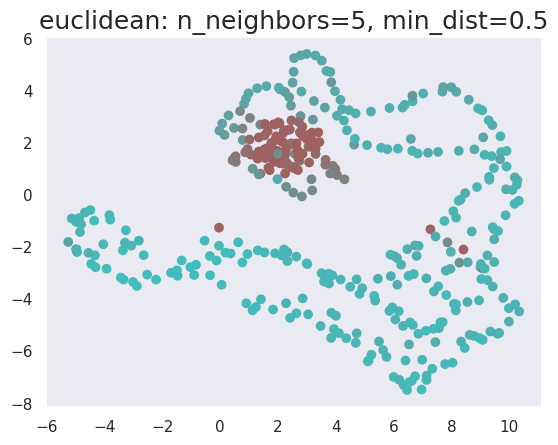

In [23]:
emb_500 = model.filter_codebook.data.cpu()
emb_color_500, zcs_500 = get_embedding_color_v2(emb_500)
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(emb_500, colors=emb_color_500, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

In [24]:
latent_emb_500 = trainer.model.latent_codebook.data.cpu()
latent_color_500, latent_zcs_500 = get_embedding_color_v2(latent_emb_500)
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(latent_emb_500, colors=latent_color_500, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

ValueError: Input contains NaN.

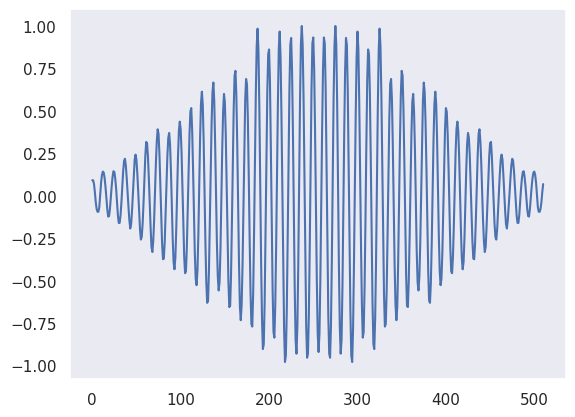

In [28]:
plt.plot(latent_emb_500[0])

In [37]:
torch.logical_not(latent_emb_500.sum(dim=-1).isnan()).type(torch.int).topk(k=10)

torch.return_types.topk(
values=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=torch.int32),
indices=tensor([119,  65,  61, 306,  44, 152,  96,   0, 127, 258]))

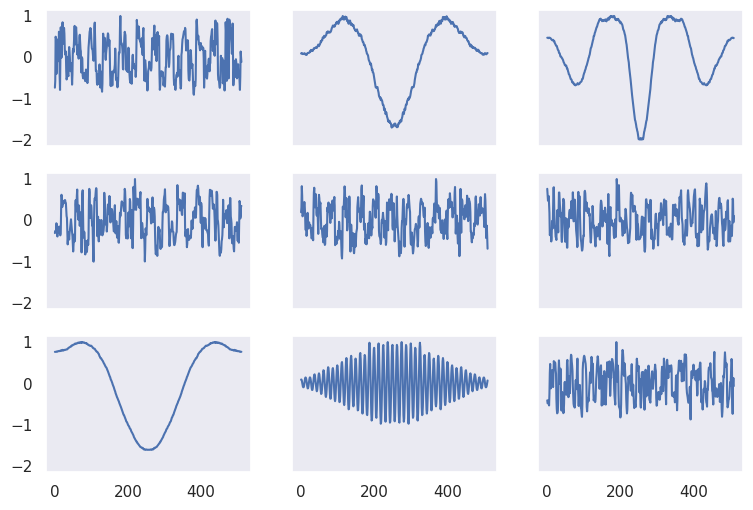

In [40]:
indices = torch.logical_not(latent_emb_500.sum(dim=-1).isnan()).type(torch.int).topk(k=9).indices
fig, axes = plt.subplots(3, 3, figsize=(9,6), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.plot(latent_emb_500[indices[i]])

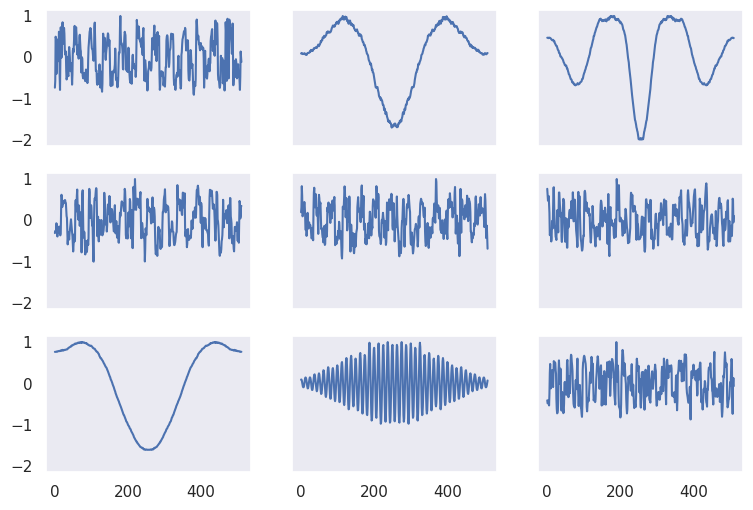

In [42]:
fig, axes = plt.subplots(3, 3, figsize=(9,6), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.plot(latent_emb_10[indices[i]])

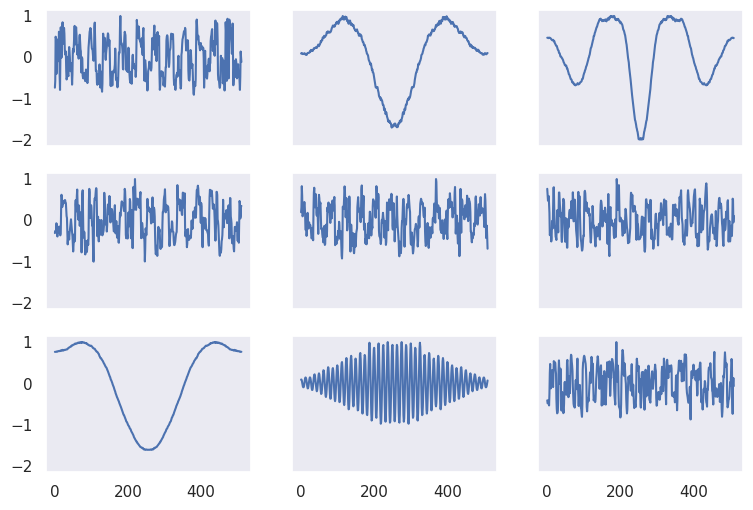

In [43]:
fig, axes = plt.subplots(3, 3, figsize=(9,6), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.plot(emb_10[indices[i]])

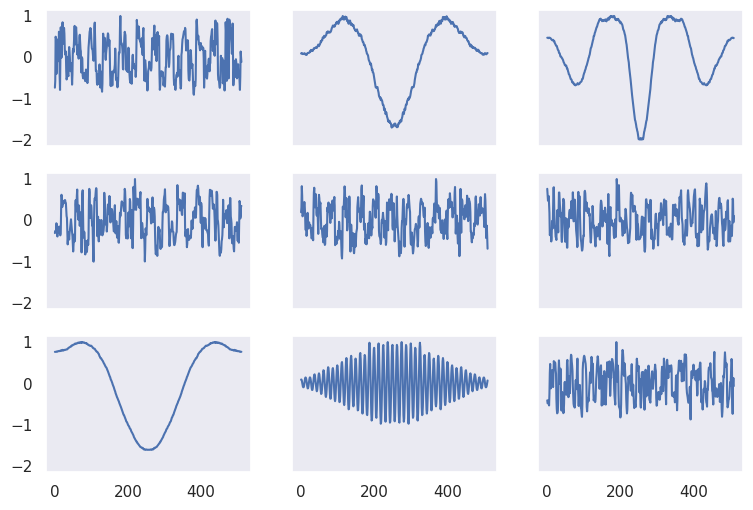

In [44]:
fig, axes = plt.subplots(3, 3, figsize=(9,6), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    ax.plot(emb[indices[i]])

In [45]:
trainer.model.latent_codebook.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [46]:
trainer.model.embedding_filters.grad

In [ ]:
visualize_speech_codebook(
    latent_emb_1k[selected_idx].numpy(), 
    n=24, colors=latent_color_1k[selected_idx], 
    feature_mel=False, waveplot_librosa=False)

In [48]:
pos_emb_500 = model.encoder.positional_embedding.weight.data.cpu()
pos_emb_color_500, pos_zcs_500 = get_embedding_color_v2(pos_emb_500)
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(pos_emb_500, colors=pos_emb_color_500, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

ValueError: Input contains NaN.

In [49]:
pos_emb_500

tensor([[        nan,         nan,         nan,  ...,         nan,
                 nan,         nan],
        [ 3.5252e-01,  1.0134e-01, -3.9827e-01,  ...,  3.6546e-01,
         -4.9282e-01,  2.1785e-01],
        [-1.4348e-01,  4.9192e-01, -1.2017e-01,  ..., -2.9696e-01,
         -2.3716e-01, -2.0465e-01],
        ...,
        [ 4.6786e-02,  2.8177e-01,  2.2626e-04,  ..., -2.5583e-01,
         -1.6128e-01,  2.2983e-01],
        [-4.3578e-01,  2.1527e-01, -7.8357e-02,  ..., -1.5812e-02,
          1.5575e-01, -4.2958e-02],
        [        nan,         nan,         nan,  ...,         nan,
                 nan,         nan]])

In [52]:
torch.logical_not(pos_emb_500.sum(dim=-1).isnan()).type(torch.int).sum()

tensor(763)

In [53]:
torch.logical_not(pos_emb_500.sum(dim=-1).isnan()).type(torch.int)

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [54]:
pos_emb_isnum_idx = torch.logical_not(pos_emb_500.sum(dim=-1).isnan())

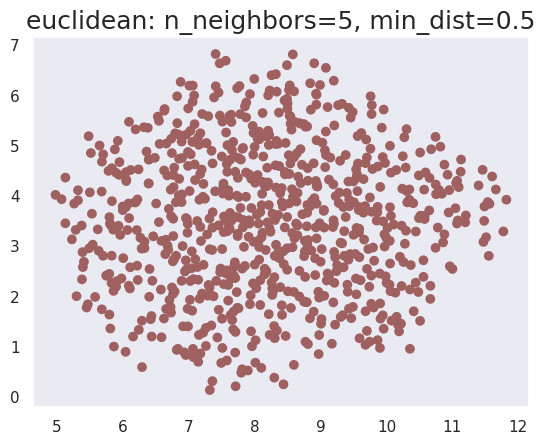

In [55]:
pos = pos_emb_500[pos_emb_isnum_idx]
pos_emb_color_500, pos_zcs_500 = get_embedding_color_v2(pos)
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(pos, colors=pos_emb_color_500, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

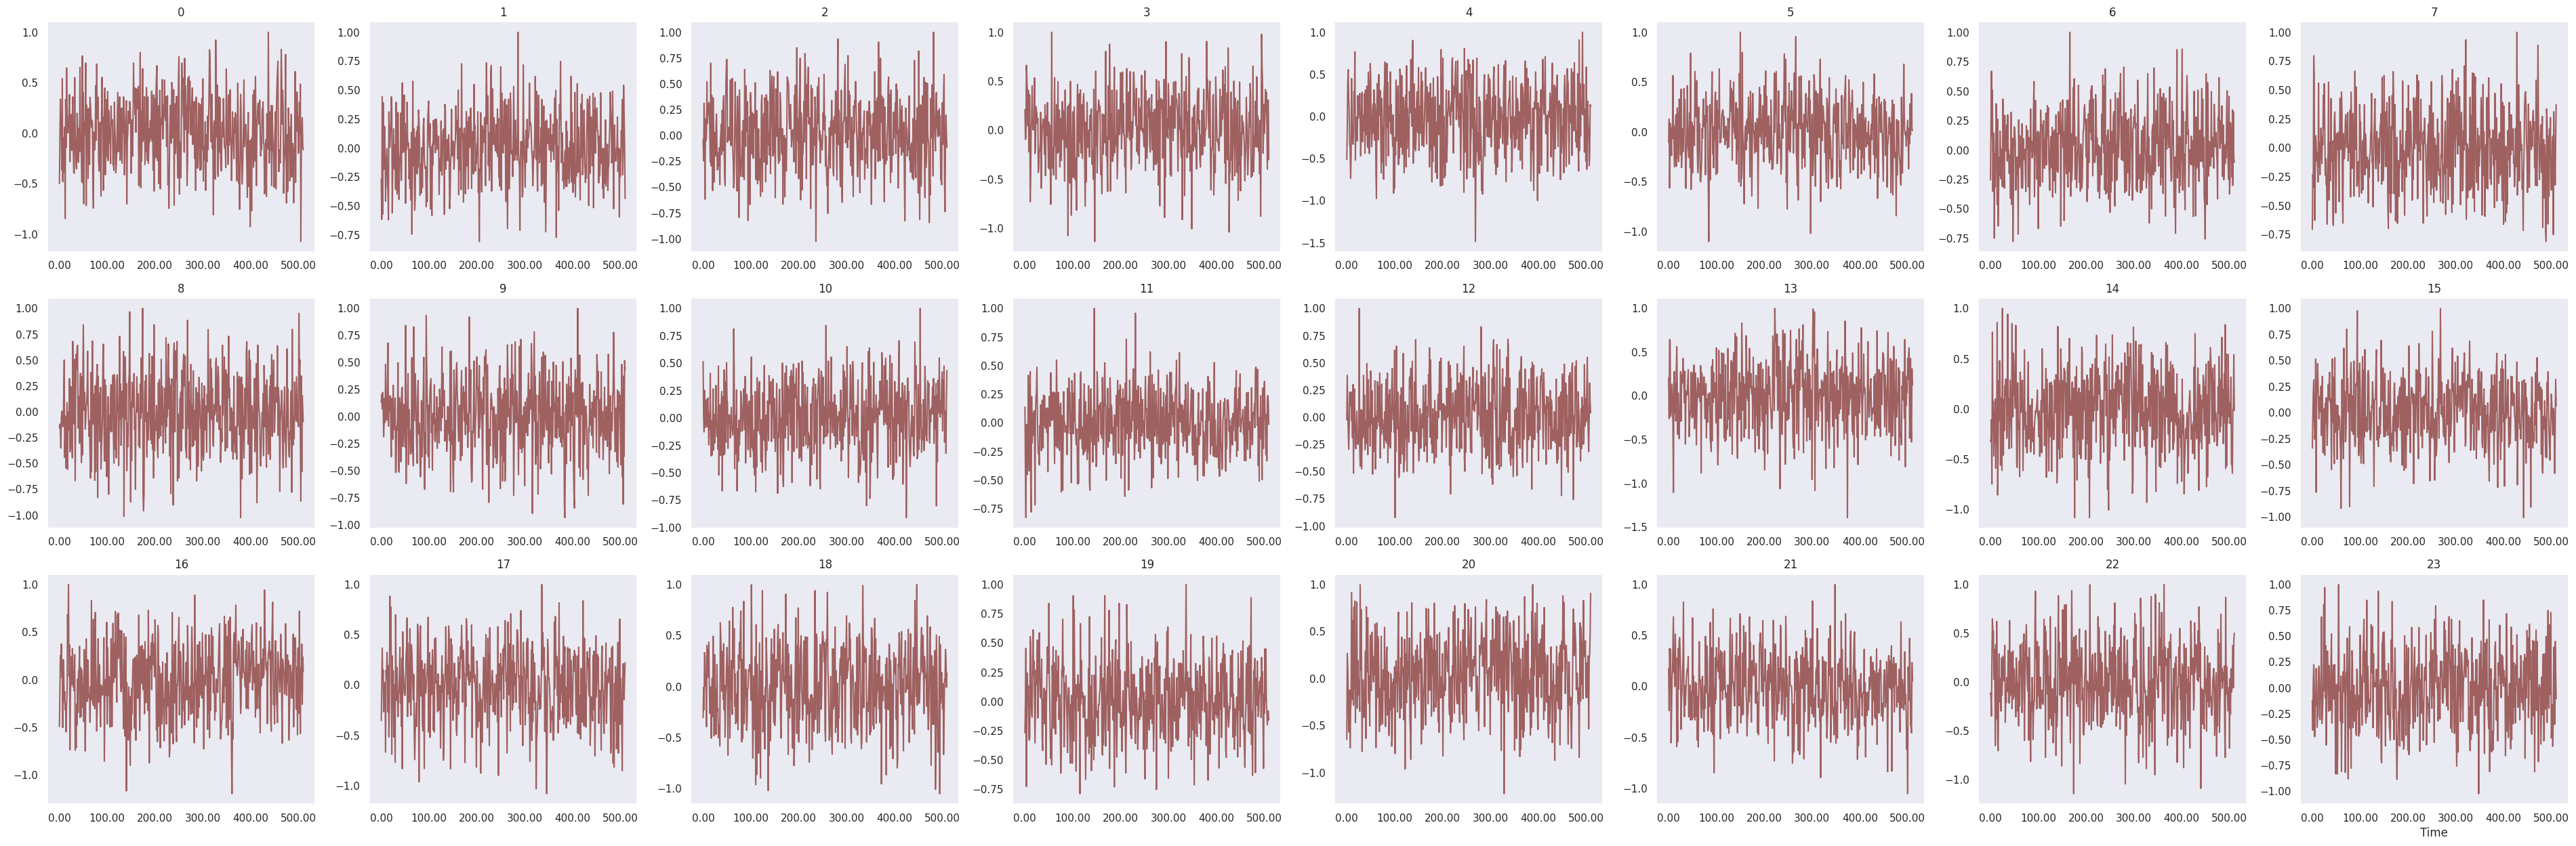

In [56]:
selected_pos_topk = torch.topk(pos_zcs_500, 24)
selected_pos_idx = selected_pos_topk.indices[-24:]
visualize_speech_codebook(
    pos[selected_pos_idx].numpy(), 
    n=24, colors=pos_emb_color_500[selected_pos_idx], 
    feature_mel=False, waveplot_librosa=False)

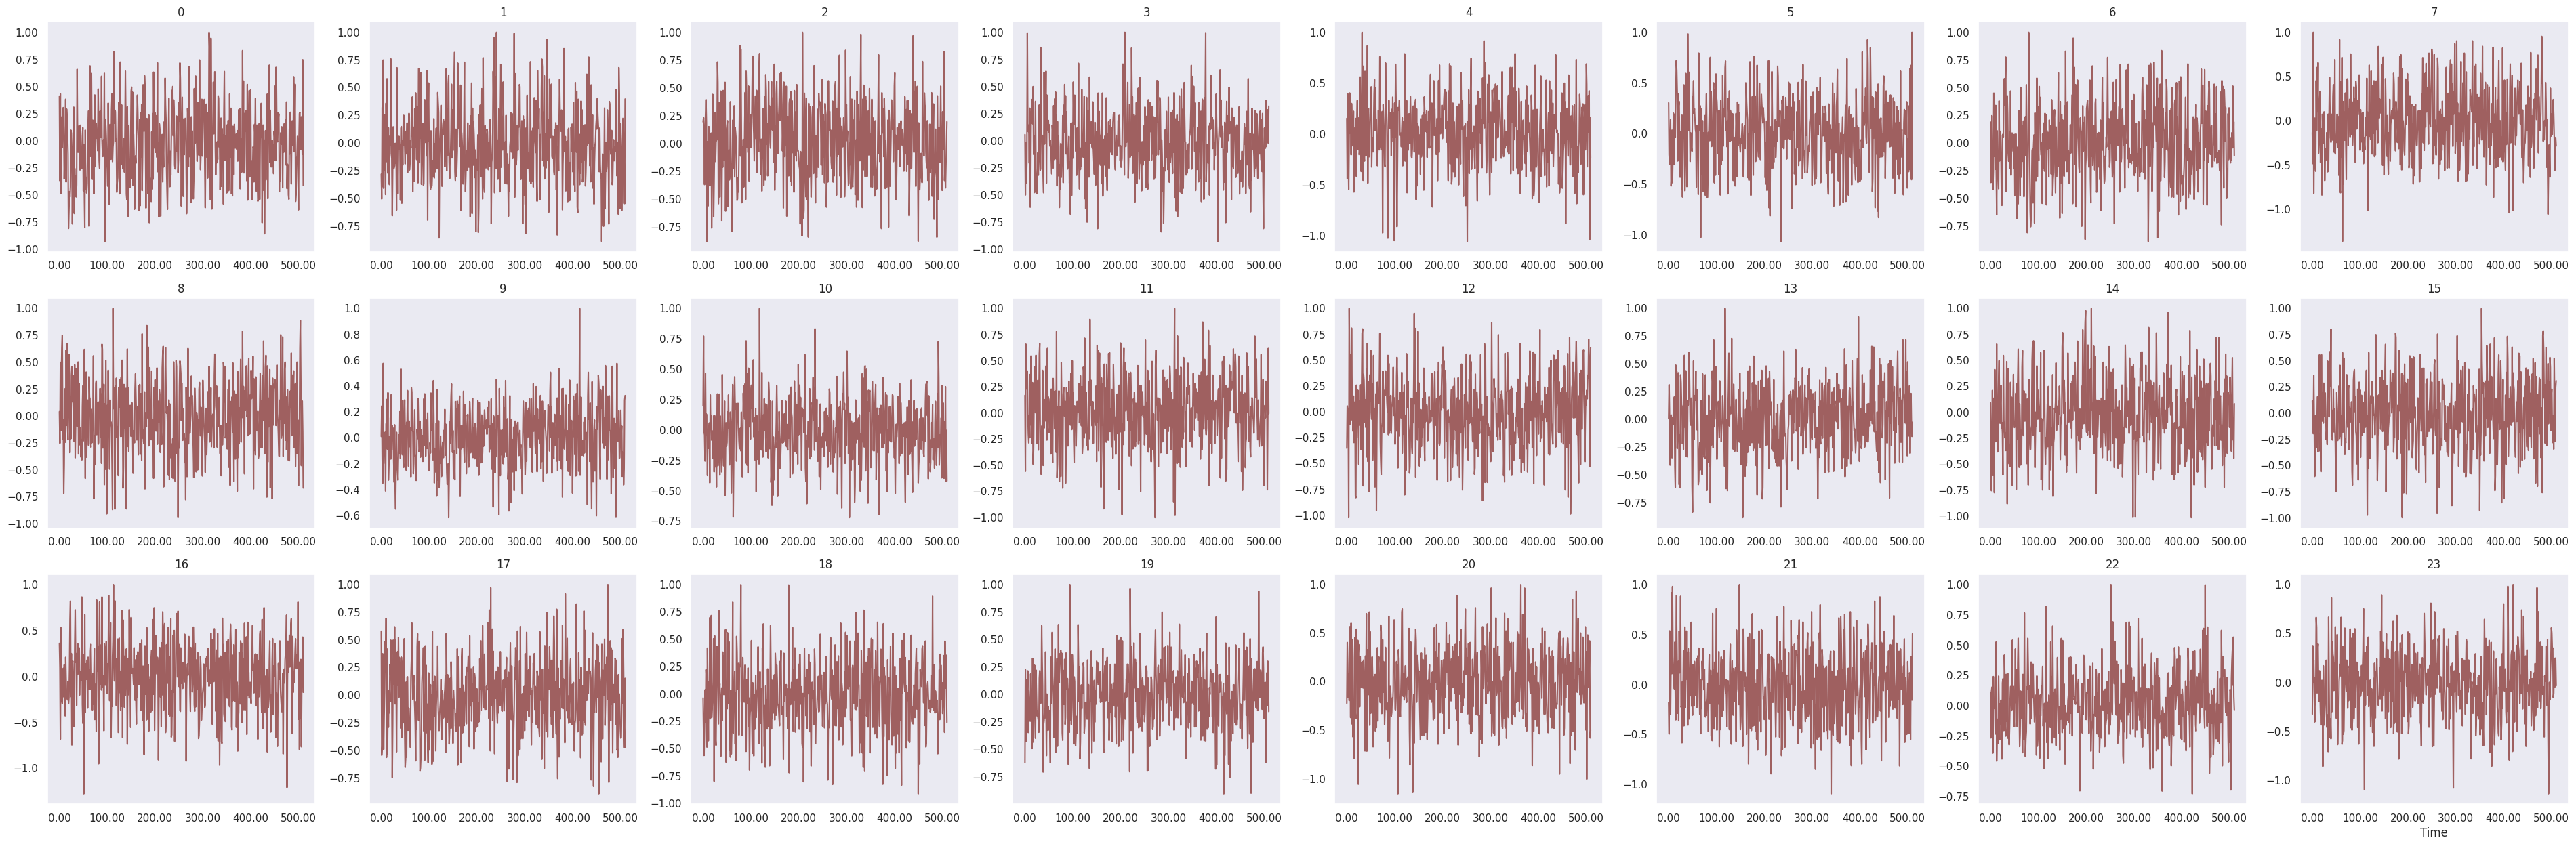

In [57]:
selected_pos_topk = torch.topk(pos_zcs_500, 700)
selected_pos_idx = selected_pos_topk.indices[-24:]
visualize_speech_codebook(
    pos[selected_pos_idx].numpy(), 
    n=24, colors=pos_emb_color_500[selected_pos_idx], 
    feature_mel=False, waveplot_librosa=False)